# Task1 Data Generation
We created a Wechat group of **6 people**, where each person sent **50 WREs**, each containing **50r**, distributed to all 6 people.

That is to say, totally **300 i.i.d. samples from the hidden distribution**. $\mathbf{X}=(X_1,X_2,\dots,X_6),\; \sum_{i=1}^6 X_i=50$

# Task2 Data Processing
## Raw Info Collecting
We made use of an auto-test software **Airtest**(Based on Image Recognition) to traverse the ChatLog to get **Snapshots of WRE Reception Record Infos**.

![Airtest](./SupportImages/Airtest.png)

## Data Extracting and Processing
We deployed **gemma3:27b** model with **Ollama** on **WSL** and **Dify** with **Docker** on **Windows Host**. Gemma3 is able to **read images**.

Then we built a workflow on **Dify**, which is able to call **gemma3** to extract **Receiver Order Index** and **Receive Amount** from a **Snapshot**, and **structure-output a json file**.

![Dify](./SupportImages/Dify.png)

Then we wrote 3 python scripts:
- `DataExtractor.py` :
  -  Connect to Dify by its **API** 
  -  Upload a snapshot
  -  Get the returned json
- `DataProcessor.py` : 
  - Get input snapshots
  - Call DataExtractor.py in loops
  - Do postprocess and output data as a json file
- `Datavisualizer.py`
  - A **Scatter** showing how much **receivers with different Receiver Order Index** receives   (*x:index* - *y:amount*)
  - A **Boxplot** showing how much **receivers with different Receiver Order Index** receives   (*x:index* - *y:amount*)
  - 6 **Histograms** showing the distribution of each receiver with different **Receiver Order Index**'s receive amount   (*x:amount* - *y:frequency*)
  - 5 **Histograms** showing the distribution of each receiver with different **Receiver Order Index**'s receive amount **given the *most frequent little sum inverval*** of all previous received amounts. (*x:amount* - *y:frequency*)

## Code

In [ ]:
import requests
import json
import os
import mimetypes
import glob
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.sans-serif"] = ["Microsoft YaHei", "SimHei", "DejaVu Sans"]

### DataExtractor

In [62]:
# ====== Configuration ======
LOCAL_DIFY_URL = "http://localhost"
API_KEY = "app-5Wjz73iI02lHt23TiDULPkIL"
USER_ID = "PositionZero"


def upload_file(file_path, user, base_url, api_key):
    upload_url = f"{base_url}/v1/files/upload"
    headers = {
        "Authorization": f"Bearer {api_key}",
    }

    try:
        with open(file_path, "rb") as file:
            mime_type, _ = mimetypes.guess_type(file_path)
            if not mime_type:
                mime_type = "application/octet-stream"

            files = {"file": (os.path.basename(file_path), file, mime_type)}
            data = {"user": user}

            response = requests.post(
                upload_url, headers=headers, files=files, data=data, timeout=60
            )
            if response.status_code == 201 or response.status_code == 200:
                return response.json()
            else:
                print(f"❌ 文件上传失败，状态码: {response.status_code}")
                try:
                    print(response.json())
                except:
                    print(response.text)
                return None
    except Exception as e:
        print(f"❌ 上传发生错误: {str(e)}")
        return None


def run_workflow(file_id, user, base_url, api_key, response_mode="blocking"):
    workflow_url = f"{base_url}/v1/workflows/run"
    headers = {"Authorization": f"Bearer {api_key}", "Content-Type": "application/json"}

    data = {
        "inputs": {
            "RedPacketInfo": {
                "transfer_method": "local_file",
                "upload_file_id": file_id,
                "type": "image",
            }
        },
        "response_mode": response_mode,
        "user": user,
    }

    try:
        response = requests.post(workflow_url, headers=headers, json=data, timeout=120)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"❌ 工作流执行失败，状态码: {response.status_code}")
            try:
                print(response.json())
            except:
                print(response.text)
            return {
                "status": "error",
                "message": f"Failed to execute workflow, status code: {response.status_code}",
            }
    except Exception as e:
        print(f"❌ 运行发生错误: {str(e)}")
        return {"status": "error", "message": str(e)}


def extract_data_from_image(
    image_path, user_id=USER_ID, base_url=LOCAL_DIFY_URL, api_key=API_KEY
):
    if not os.path.exists(image_path):
        print(f"❌ 找不到图片文件，请检查路径：{image_path}")
        return None

    upload_resp = upload_file(image_path, user_id, base_url, api_key)

    if upload_resp and "id" in upload_resp:
        file_id = upload_resp["id"]

        run_resp = run_workflow(file_id, user_id, base_url, api_key)

        # 解析 run 响应以提取 outputs
        run_output = None
        if (
            isinstance(run_resp, dict)
            and "data" in run_resp
            and isinstance(run_resp["data"], dict)
            and "outputs" in run_resp["data"]
        ):
            run_output = run_resp["data"]["outputs"]
        else:
            run_output = run_resp

        try:
            text_content = run_output.get("text")
            if "```json" in text_content:
                text_content = text_content.replace("```json", "").replace("```", "")

            parsed_json = json.loads(text_content)

            # Attempt to locate the list of items
            info = None
            if isinstance(parsed_json, dict):
                # 1. Try exact match
                if "red_packets" in parsed_json:
                    info = parsed_json["red_packets"]
                # 2. Search for any list value if specific key is missing
                else:
                    for key, value in parsed_json.items():
                        if isinstance(value, list):
                            info = value
                            break
            elif isinstance(parsed_json, list):
                # 3. The root object itself is the list
                info = parsed_json

            if info is None:
                raise ValueError("Cannot locate a valid data list in response.")

            data = []
            for i in range(len(info) - 1, -1, -1):
                amount_str = info[i].get("ReceiveAmount", "0")
                amount_str = str(amount_str).replace("元", "")
                data.append(float(amount_str))
            return data
        except Exception as e:
            print(f"Error parsing data: {e}")
            return None

    else:
        print("文件上传失败，无法执行工作流")
        return None


### DataProcessor

In [63]:
OUTPUT_DIR = "Output/"  # Temporary output directory for test-generated data
DATABASE_DIR = "Database/"  # Acknowledged and manually transferred long-term data storage from OUTPUT_DIR

def process_all_snapshots():
    # Cleanup: Delete all temp generated .jpgs in Snapshots/
    jpg_files = glob.glob(os.path.join("Snapshots", "*.jpg"))
    if jpg_files:
        for f in jpg_files:
            try:
                os.remove(f)
            except Exception as e:
                print(f"Failed to delete {f}: {e}")

    snapshot_files = glob.glob(os.path.join("Snapshots", "info*.png"))

    snapshot_files.sort()

    data = []

    for file_path in snapshot_files:
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue

        file_data = extract_data_from_image(file_path)

        if file_data:
            data.append(file_data)
        else:
            print(f"Failed to extract data from {file_path}")

    if not data:
        print("No data collected.")
        return

    # Save data to a JSON
    output_json_path = os.path.join(OUTPUT_DIR, "Wechat_Samples.json")

    try:
        with open(output_json_path, "w", encoding="utf-8") as f:
            json.dump(data, f, ensure_ascii=False, indent=4)
    except Exception as e:
        print(f"Error saving data to file: {e}")


### DataVisualizer

In [ ]:
def visualize_data(data):
    plt.figure(figsize=(12, 6))

    # Data logic for plotting
    # Example: data = [[A1, B1], [A2, B2], [A3, B3]]
    # Index 0 (A): Values (A1, A2, A3)
    # Index 1 (B): Values (B1, B2, B3)

    # Determine maximum dimension length
    max_len = max(len(d) for d in data) if data else 0

    # 1. Overlay Plot: Vertical Scatter (Index vs Value)
    plt.figure(figsize=(12, 6))

    # 1. Prepare data by dimension
    data_by_dimension = []
    for dim_idx in range(max_len):
        values = [snap[dim_idx] for snap in data if dim_idx < len(snap)]
        data_by_dimension.append(values)

    # 2. Overlay Plot: Vertical Scatter (Index vs Value)
    plt.figure(figsize=(12, 6))

    for dim_idx, values in enumerate(data_by_dimension):
        if values:
            # Add random jitter to x coordinates
            jitter = np.random.uniform(-0.1, 0.1, len(values))
            x = np.array([dim_idx] * len(values)) + jitter

            plt.scatter(
                x,
                values,
                alpha=0.6,
                s=50,
                label=f"Dim {dim_idx}" if dim_idx == 0 else "",
            )

    plt.title("All Value Distribution (Scatter)")
    plt.xlabel("Receiver Order Index")
    plt.ylabel("Value (元)")
    plt.xticks(range(max_len))
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    # 3. Overlay Plot: Vertical Boxplot (Index vs Value)
    plt.figure(figsize=(12, 6))
    plt.boxplot(data_by_dimension, tick_labels=range(max_len))

    plt.title("All Value Distribution (Boxplot)")
    plt.xlabel("Receiver Order Index")
    plt.ylabel("Value (元)")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    # 4. Individual Plots: Histogram (Value Distribution)
    for dim_idx, values in enumerate(data_by_dimension):
        if not values:
            continue

        plt.figure(figsize=(10, 6))

        plt.hist(values, bins=20, color="teal", alpha=0.7, edgecolor="black")

        plt.title(f"Distribution Histogram for Receiver # {dim_idx}")
        plt.xlabel("Value (元)")
        plt.ylabel("Frequency")
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.show()
    # Generate conditional histograms
    visualize_conditional_histograms(data)


def visualize_conditional_histograms(data):
    max_len = max(len(d) for d in data) if data else 0

    # k corresponds to dimensions X_k where k > 1 (1-based) => indices 1, 2, ...
    for dim_idx in range(1, max_len):
        pairs = []
        for sample in data:
            if dim_idx < len(sample):
                # Sum of previous dimensions X_0 ... X_{k-1}
                prev_sum = sum(sample[:dim_idx])
                val = sample[dim_idx]
                pairs.append((prev_sum, val))

        if not pairs:
            continue

        sums = [p[0] for p in pairs]

        # Determine the most frequent interval (mode) for the sums
        if not sums:
            continue

        # Use bins='auto' or a fixed number large enough to validly capture the peak
        counts, bin_edges = np.histogram(sums, bins="auto")
        if len(counts) == 0:
            continue

        max_bin_idx = np.argmax(counts)
        range_min = bin_edges[max_bin_idx]
        range_max = bin_edges[max_bin_idx + 1]

        # Filter X_k where sum is in this interval
        # Note: np.histogram includes right edge for the last bin, but generally [a, b)
        # We will use the edges directly.
        filtered_values = [val for s, val in pairs if range_min <= s <= range_max]

        if not filtered_values:
            continue

        plt.figure(figsize=(10, 6))
        plt.hist(filtered_values, bins=20, color="purple", alpha=0.7, edgecolor="black")

        plt.title(
            f"Hist for X_{dim_idx} | Sum(X_0..X_{dim_idx-1}) in [{range_min:.2f}, {range_max:.2f}]"
        )
        plt.xlabel(f"X_{dim_idx} Value")
        plt.ylabel("Frequency")
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.show()

### Main

Loading data from Database/Wechat_Samples.json...


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

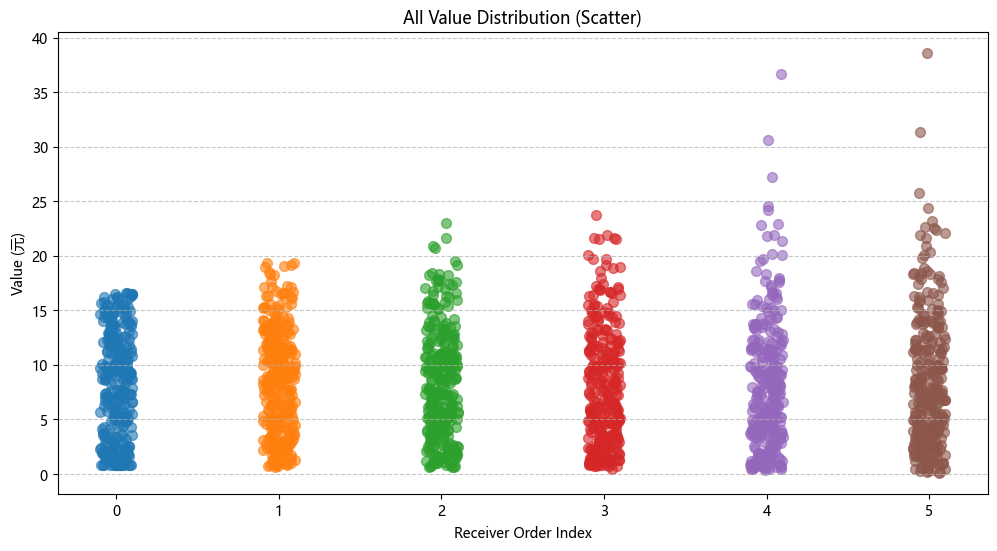

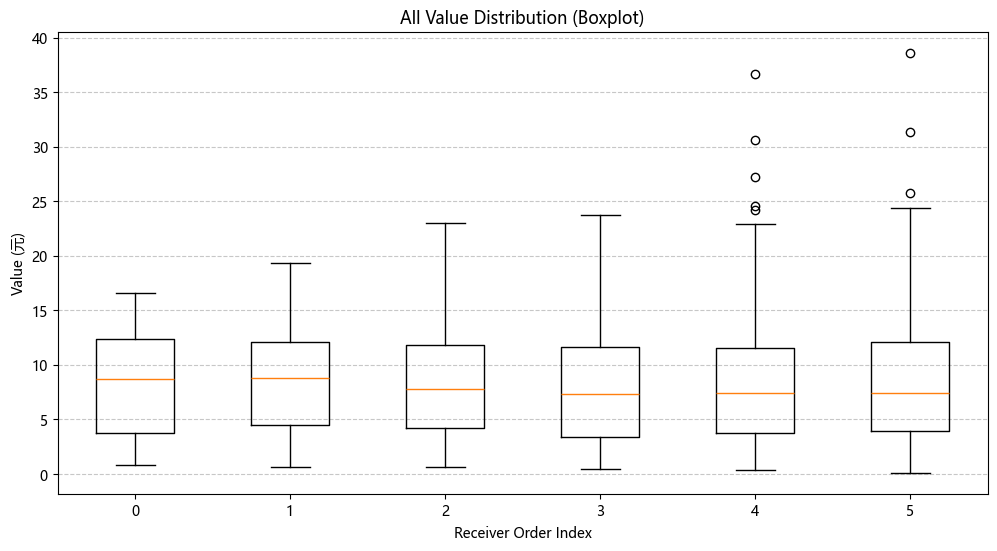

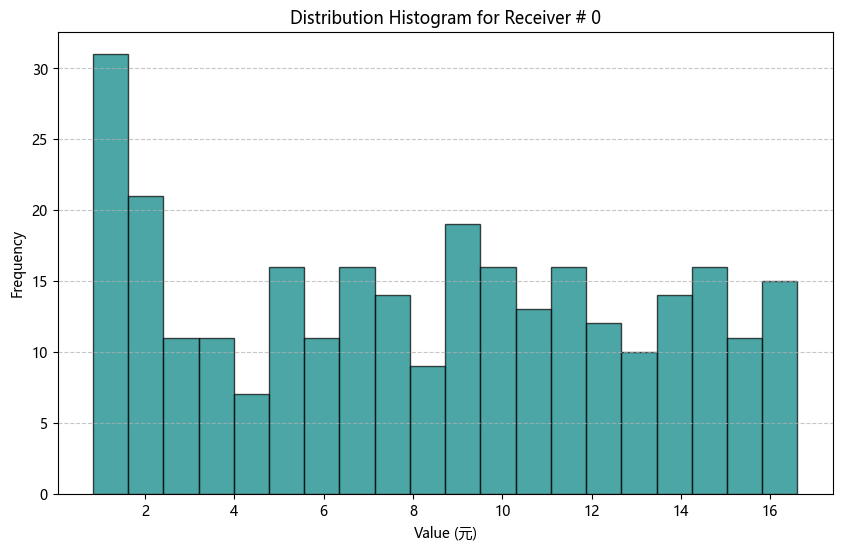

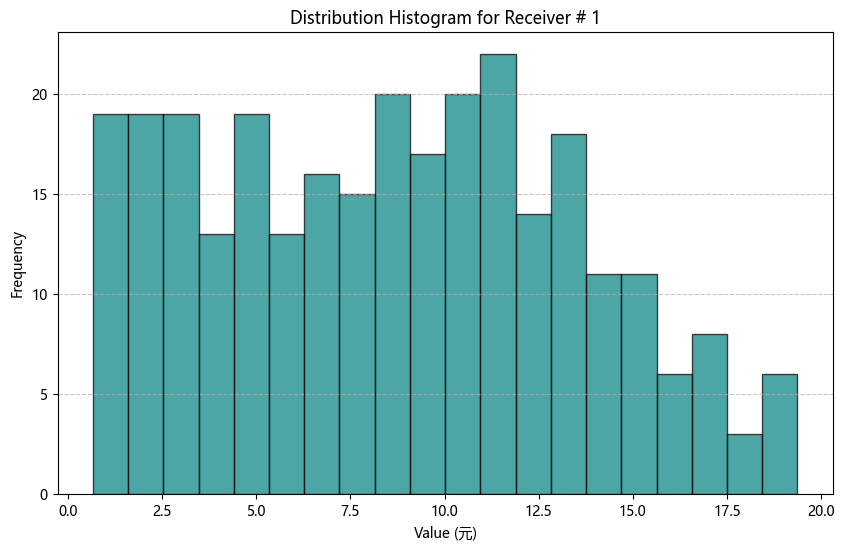

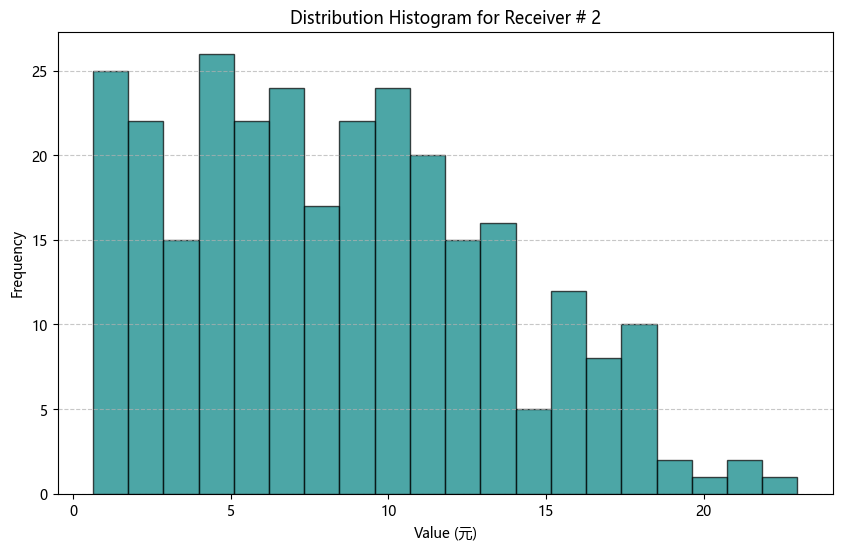

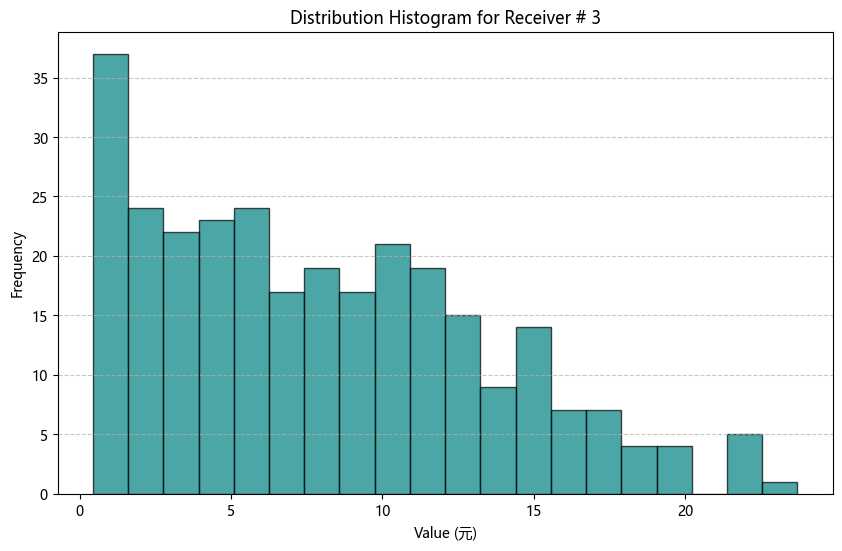

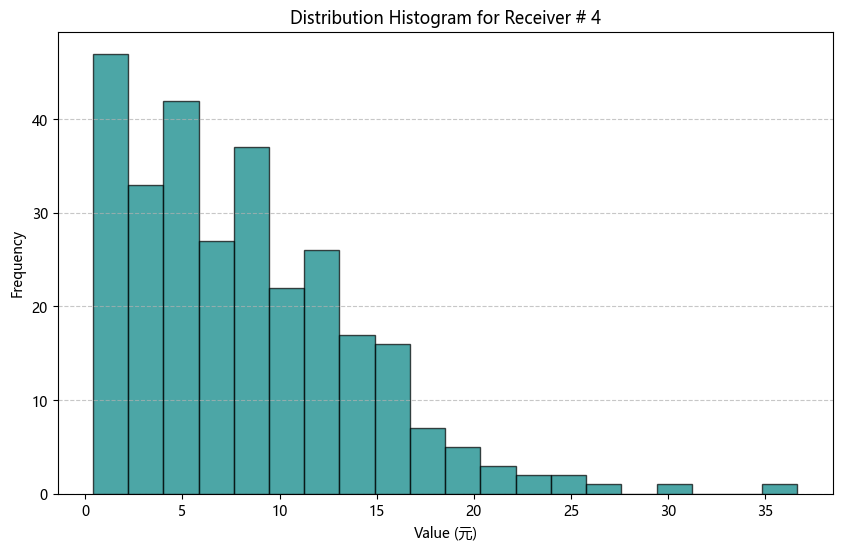

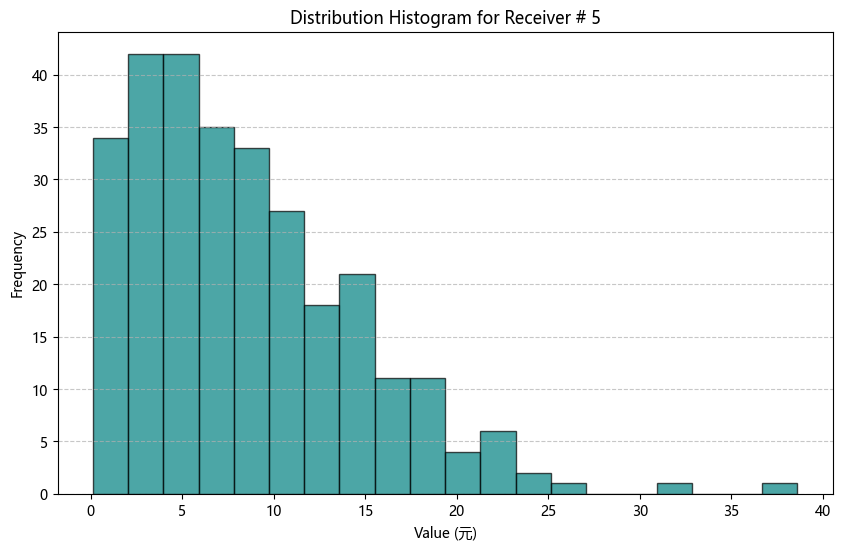

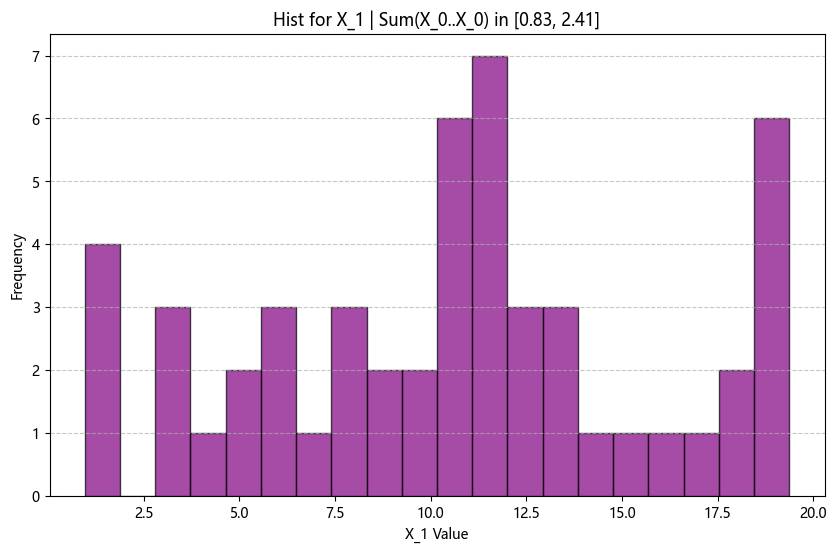

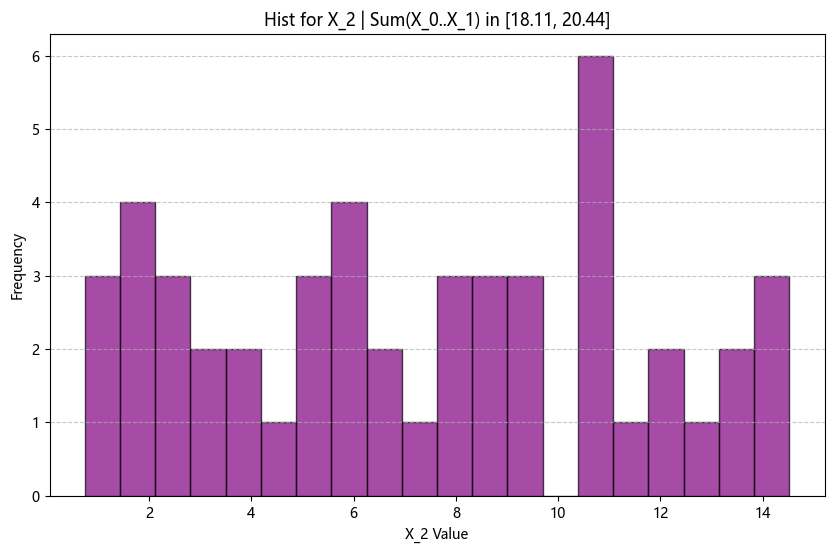

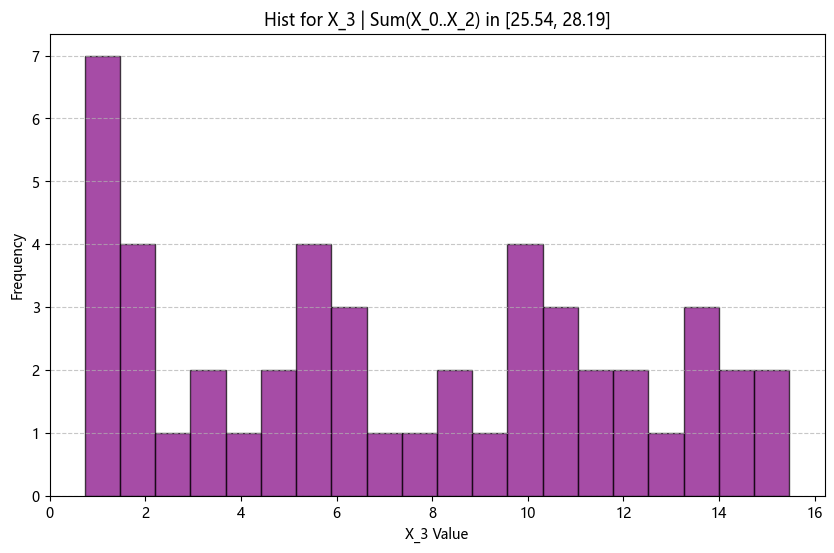

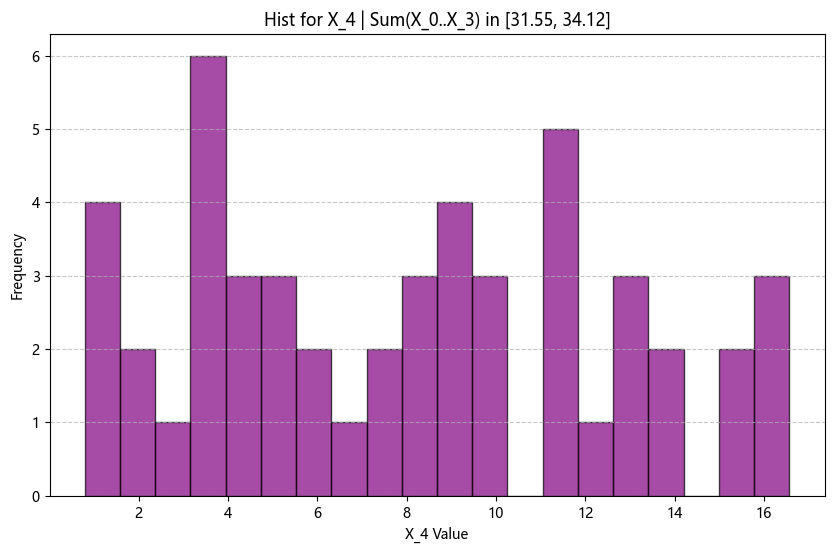

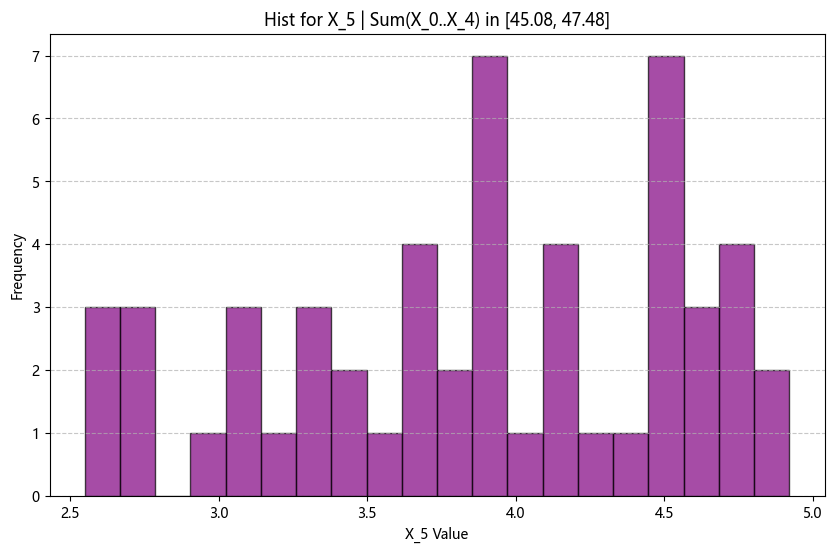

In [65]:
# Load Wechat_Samples.json if it exists, otherwise process snapshots
data_path = os.path.join(DATABASE_DIR, "Wechat_Samples.json")

if os.path.exists(data_path):
    print(f"Loading data from {data_path}...")
    try:
        with open(data_path, "r", encoding="utf-8") as f:
            data = json.load(f)
        visualize_data(data)
    except Exception as e:
        print(f"Error loading data from file: {e}")
        print("Falling back to processing snapshots...")
        process_all_snapshots()
else:
    process_all_snapshots()

# Task3 Distribution Modeling

In [19]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, chisquare, ttest_ind

We construct two models: **Normal** and **Conditional Uniform** to try to explain the data distribution.
## Normal Model
We estimate the Normal parameters $\mu$ and $\sigma$ by using Maximum Likelihood Estimation method and generate an
example sample data from model following the experienced normal distribution.
### 1. Core Idea

*   **Likelihood Function:** $L(\theta | x_1, ..., x_n)$ represents the **probability** (discrete) or **probability density** (continuous) of observing the specific dataset $x_1, ..., x_n$ given the parameter $\theta$.
*   **Maximization:** MLE aims to find a set of parameters $\hat{\theta}$ that maximizes the likelihood function $L(\theta | ...)$. This $\hat{\theta}$ is our estimate for the true parameter $\theta$.
* ## 2. Applying MLE to Estimate Normal Distribution Parameters

**Assumption:** We have $n$ independent and identically distributed (i.i.d.) observations $x_1, x_2, ..., x_n$, drawn from a Normal distribution $N(\mu, \sigma^2)$ with unknown mean $\mu$ and unknown variance $\sigma^2$.

#### 2.1. Write the Likelihood Function

*   Because the observations are independent, the joint probability density is the product of individual densities.
*   $f(x_i | \mu, \sigma^2)$ is the probability density function (PDF) of the Normal distribution.
*   $L(\mu, \sigma^2 | x_1, ..., x_n)$ is the likelihood function.

$$
L(\mu, \sigma^2 | x_1, ..., x_n) = \prod_{i=1}^{n} f(x_i | \mu, \sigma^2)
$$

$$
f(x_i | \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x_i - \mu)^2}{2\sigma^2}\right)
$$

$$
L(\mu, \sigma^2) = \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x_i - \mu)^2}{2\sigma^2}\right) \tag{1}
$$

#### 2.2. Take the Log-Likelihood Function

*   To simplify differentiation and calculation (turning products into sums), take the natural logarithm of the likelihood function.
*   $\ell(\mu, \sigma^2)$ is the log-likelihood function.

$$
\ell(\mu, \sigma^2) = \log L(\mu, \sigma^2) = \sum_{i=1}^{n} \log\left(\frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x_i - \mu)^2}{2\sigma^2}\right)\right) \tag{2}
$$

Expand and simplify (using logarithm properties):

$$
\ell(\mu, \sigma^2) = \sum_{i=1}^{n} \left[ \log\left((2\pi\sigma^2)^{-1/2}\right) + \log\left(\exp\left(-\frac{(x_i - \mu)^2}{2\sigma^2}\right)\right) \right]
$$

$$
= \sum_{i=1}^{n} \left[ -\frac{1}{2}\log(2\pi) - \frac{1}{2}\log(\sigma^2) - \frac{(x_i - \mu)^2}{2\sigma^2} \right] \tag{3}
$$

$$
= -\frac{n}{2}\log(2\pi) - \frac{n}{2}\log(\sigma^2) - \frac{1}{2\sigma^2}\sum_{i=1}^{n}(x_i - \mu)^2 \tag{4}
$$

#### 2.3. Differentiate with Respect to Parameters and Set to Zero

*   To find the maximum, differentiate with respect to $\mu$ and $\sigma^2$ separately, and set the results equal to zero.

##### 2.3.1. Differentiate with Respect to $\mu$

*   Treat $\sigma^2$ as a constant when differentiating with respect to $\mu$.

$$
\frac{\partial \ell}{\partial \mu} = \frac{\partial}{\partial \mu} \left( -\frac{n}{2}\log(2\pi) - \frac{n}{2}\log(\sigma^2) - \frac{1}{2\sigma^2}\sum_{i=1}^{n}(x_i - \mu)^2 \right)
$$

$$
= 0 - 0 - \frac{1}{2\sigma^2} \cdot \sum_{i=1}^{n} \frac{\partial}{\partial \mu} (x_i - \mu)^2
$$

$$
= - \frac{1}{2\sigma^2} \cdot \sum_{i=1}^{n} 2(x_i - \mu) \cdot (-1) \tag{Chain Rule}
$$

$$
= \frac{1}{\sigma^2}\sum_{i=1}^{n}(x_i - \mu) \tag{5}
$$

Set $\frac{\partial \ell}{\partial \mu} = 0$:

$$
\sum_{i=1}^{n}(x_i - \mu) = 0 \implies \sum_{i=1}^{n}x_i - n\mu = 0 \implies \sum_{i=1}^{n}x_i = n\mu \implies \mu = \frac{1}{n}\sum_{i=1}^{n}x_i \tag{6}
$$

##### 2.3.2. Differentiate with Respect to $\sigma^2$

*   Treat $\mu$ as a constant (using the value solved for in Step 2.3.1), when differentiating with respect to $\sigma^2$.

$$
\frac{\partial \ell}{\partial \sigma^2} = \frac{\partial}{\partial \sigma^2} \left( -\frac{n}{2}\log(2\pi) - \frac{n}{2}\log(\sigma^2) - \frac{1}{2\sigma^2}\sum_{i=1}^{n}(x_i - \mu)^2 \right)
$$

$$
= 0 - \frac{n}{2} \cdot \frac{1}{\sigma^2} - \sum_{i=1}^{n}(x_i - \mu)^2 \cdot \frac{\partial}{\partial \sigma^2} \left( \frac{1}{2\sigma^2} \right)
$$

$$
= -\frac{n}{2\sigma^2} - \sum_{i=1}^{n}(x_i - \mu)^2 \cdot \left( -\frac{1}{2(\sigma^2)^2} \right) \tag{Derivative of 1/x w.r.t. x}
$$

$$
= -\frac{n}{2\sigma^2} + \frac{1}{2(\sigma^2)^2}\sum_{i=1}^{n}(x_i - \mu)^2 \tag{7}
$$

Set $\frac{\partial \ell}{\partial \sigma^2} = 0$:

$$
-\frac{n}{2\sigma^2} + \frac{1}{2(\sigma^2)^2}\sum_{i=1}^{n}(x_i - \mu)^2 = 0
$$

$$
\frac{n}{2\sigma^2} = \frac{1}{2(\sigma^2)^2}\sum_{i=1}^{n}(x_i - \mu)^2
$$

Multiply both sides by $2(\sigma^2)^2$:

$$
n \cdot \sigma^2 = \sum_{i=1}^{n}(x_i - \mu)^2 \implies \sigma^2 = \frac{1}{n}\sum_{i=1}^{n}(x_i - \mu)^2 \tag{8}
$$

#### 2.4. Obtain the MLE Estimators

*   Substitute the $\hat{\mu}$ value obtained from equation (6) into equation (8).

*   **MLE estimator for mean $\mu$:**
    $$
    \hat{\mu}_{MLE} = \frac{1}{n}\sum_{i=1}^{n}x_i \tag{9}
    $$

*   **MLE estimator for variance $\sigma^2$:**
    $$
    \hat{\sigma}^2_{MLE} = \frac{1}{n}\sum_{i=1}^{n}(x_i - \hat{\mu}_{MLE})^2 \tag{10}
    $$
### 3. Conclusion

Through the MLE method, we derived that:

*   The best estimate for the mean $\mu$ of a Normal distribution is the **sample mean**.
*   The best estimate for the variance $\sigma^2$ of a Normal distribution is the **sample variance with denominator $n$**.

In [20]:
def load_data(json_file_path):
    if not os.path.exists(json_file_path):
        raise FileNotFoundError(f"JSON file '{json_file_path}' not found in the current directory.")
    try:
        with open(json_file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        return data
    except Exception as e:
        print(f"Error loading JSON file: {e}")
        return None

## Conditional Uniform Model
By applying a hypothesized distribution rule :
**Every single r.v. follows uniform distribution with lower bound 0.01 and higher bound 2 times average of the remaining**, we construct this **conditional** uniform model and use it to generate an example sample data with n steps
(n equals to the total number of red packets).


Simulated data: 200 groups, 1200 individual amounts
Simulated data range: 0.07 ~ 32.37
Simulated data mean: 8.33, std: 5.61


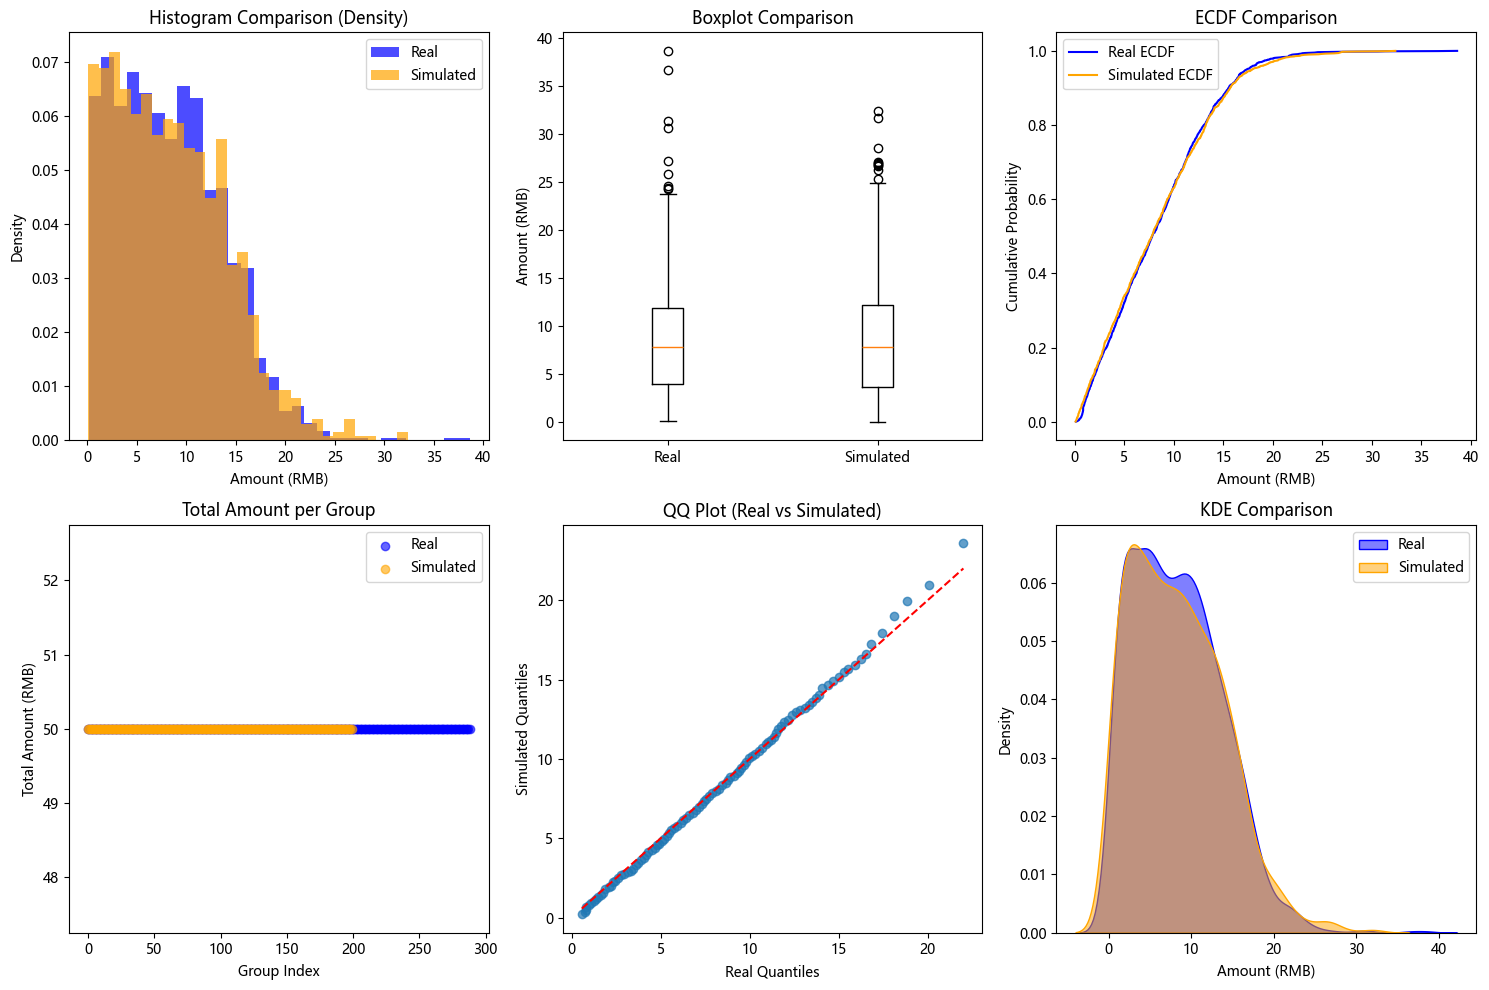


Statistical Tests for Distribution Comparison
Kolmogorov-Smirnov Test:
  KS statistic = 0.0297
  p-value = 0.5466
  → Cannot reject H0: Same distribution (p > 0.05)

Chi-square Goodness-of-fit Test:
  Real data total: 1734.5
  Expected total: 1734.5
  Difference: 0.0000000000
  Chi2 statistic = 12.0102
  p-value = 0.2127
  Degrees of freedom = 9
  Number of bins used = 10
  → Cannot reject H0: Good fit (p > 0.05)

Welch's t-test for means:
  t-statistic = 0.0000
  p-value = 1.0000
  → Cannot reject H0: Same mean (p > 0.05)

Descriptive Statistics:
  Real data skewness: 0.6863
  Simulated data skewness: 0.6763
  Real data kurtosis: 3.7138
  Simulated data kurtosis: 3.2805

Conclusion
The simulated data (0–2×avg uniform model) is statistically consistent
with the provided WeChat Red Envelope sample data.
The model reasonably captures the underlying random mechanism.

Test results summary (3/3 tests passed):
  KS_test: PASS
  T_test: PASS
  Chi2_test: PASS

Key differences:
  Real data m

In [21]:
DATABASE_DIR = "Database/Wechat_Samples.json"
with open(DATABASE_DIR, 'r') as f:
    real_data = json.load(f)
real_data_flat = np.array(real_data).flatten()
# Define Simulation Function 
def simulate_one_group(total=50, n=6):
    amounts = []
    remaining = total
    for i in range(n - 1):
        avg_remaining = remaining / (n - i)
        draw = np.random.uniform(0, 2 * avg_remaining)
        amounts.append(draw)
        remaining -= draw
    amounts.append(remaining)  # last person gets the rest
    return amounts

def simulate_many_groups(num_groups=200, total=50, n=6):
    groups = []
    for _ in range(num_groups):
        groups.append(simulate_one_group(total, n))
    return groups

# Generate Simulated Data 
np.random.seed(42)
simulated_data = simulate_many_groups(num_groups=200, total=50, n=6)
simulated_data_flat = np.array(simulated_data).flatten()
print(f"\nSimulated data: {len(simulated_data)} groups, {len(simulated_data_flat)} individual amounts")
print(f"Simulated data range: {simulated_data_flat.min():.2f} ~ {simulated_data_flat.max():.2f}")
print(f"Simulated data mean: {simulated_data_flat.mean():.2f}, std: {simulated_data_flat.std():.2f}")

# Visualization 
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Histograms
axes[0, 0].hist(real_data_flat, bins=30, alpha=0.7, color='blue', label='Real', density=True)
axes[0, 0].hist(simulated_data_flat, bins=30, alpha=0.7, color='orange', label='Simulated', density=True)
axes[0, 0].set_title('Histogram Comparison (Density)')
axes[0, 0].set_xlabel('Amount (RMB)')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()

# Boxplots
box_data = [real_data_flat, simulated_data_flat]
axes[0, 1].boxplot(box_data, tick_labels=['Real', 'Simulated'])
axes[0, 1].set_title('Boxplot Comparison')
axes[0, 1].set_ylabel('Amount (RMB)')

# ECDF plots
def ecdf(data):
    sorted_data = np.sort(data)
    y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, y

real_x, real_y = ecdf(real_data_flat)
sim_x, sim_y = ecdf(simulated_data_flat)
axes[0, 2].plot(real_x, real_y, label='Real ECDF', color='blue')
axes[0, 2].plot(sim_x, sim_y, label='Simulated ECDF', color='orange')
axes[0, 2].set_title('ECDF Comparison')
axes[0, 2].set_xlabel('Amount (RMB)')
axes[0, 2].set_ylabel('Cumulative Probability')
axes[0, 2].legend()

# Scatter of group totals
real_totals = [sum(g) for g in real_data]
sim_totals = [sum(g) for g in simulated_data]
axes[1, 0].scatter(range(len(real_totals)), real_totals, alpha=0.6, label='Real', color='blue')
axes[1, 0].scatter(range(len(sim_totals)), sim_totals, alpha=0.6, label='Simulated', color='orange')
axes[1, 0].set_title('Total Amount per Group')
axes[1, 0].set_xlabel('Group Index')
axes[1, 0].set_ylabel('Total Amount (RMB)')
axes[1, 0].legend()

# QQ plot
quantiles = np.linspace(0.01, 0.99, 100)
real_quantiles = np.quantile(real_data_flat, quantiles)
sim_quantiles = np.quantile(simulated_data_flat, quantiles)
axes[1, 1].scatter(real_quantiles, sim_quantiles, alpha=0.7)
axes[1, 1].plot([real_quantiles.min(), real_quantiles.max()],
                [real_quantiles.min(), real_quantiles.max()], 'r--')
axes[1, 1].set_title('QQ Plot (Real vs Simulated)')
axes[1, 1].set_xlabel('Real Quantiles')
axes[1, 1].set_ylabel('Simulated Quantiles')

# Kernel Density Estimate
sns.kdeplot(real_data_flat, ax=axes[1, 2], label='Real', fill=True, alpha=0.5, color='blue')
sns.kdeplot(simulated_data_flat, ax=axes[1, 2], label='Simulated', fill=True, alpha=0.5, color='orange')
axes[1, 2].set_title('KDE Comparison')
axes[1, 2].set_xlabel('Amount (RMB)')
axes[1, 2].set_ylabel('Density')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

# Statistical Tests
print("\n" + "="*50)
print("Statistical Tests for Distribution Comparison")
print("="*50)

# Kolmogorov-Smirnov test
ks_stat, ks_p = ks_2samp(real_data_flat, simulated_data_flat)
print(f"Kolmogorov-Smirnov Test:")
print(f"  KS statistic = {ks_stat:.4f}")
print(f"  p-value = {ks_p:.4f}")
if ks_p > 0.05:
    print("  → Cannot reject H0: Same distribution (p > 0.05)")
else:
    print("  → Reject H0: Different distributions (p ≤ 0.05)")

# Chi-square test
print(f"\nChi-square Goodness-of-fit Test:")
bins = np.linspace(0, 40, 15)
real_hist, bin_edges = np.histogram(real_data_flat, bins=bins)
sim_hist, _ = np.histogram(simulated_data_flat, bins=bins)

# 确保没有零频数
real_hist = np.where(real_hist == 0, 0.5, real_hist)
sim_hist = np.where(sim_hist == 0, 0.5, sim_hist)

# 计算模拟数据的概率分布
sim_probs = sim_hist / np.sum(sim_hist)

# 计算期望频数：模拟数据的概率分布 × 真实数据的总样本数
expected_freq = sim_probs * np.sum(real_hist)

# 调整期望频数以确保总和完全一致
expected_freq = expected_freq * (np.sum(real_hist) / np.sum(expected_freq))

print(f"  Real data total: {np.sum(real_hist)}")
print(f"  Expected total: {np.sum(expected_freq)}")
print(f"  Difference: {np.abs(np.sum(real_hist) - np.sum(expected_freq)):.10f}")

# 检查是否有足够的数据进行卡方检验
valid_mask = expected_freq >= 5
if np.sum(valid_mask) >= 3:
    # 使用有效区间
    real_hist_valid = real_hist[valid_mask]
    expected_freq_valid = expected_freq[valid_mask]
    
    # 再次确保总和一致
    expected_freq_valid = expected_freq_valid * (np.sum(real_hist_valid) / np.sum(expected_freq_valid))
    
    try:
        chi2_stat, chi2_p = chisquare(f_obs=real_hist_valid, f_exp=expected_freq_valid)
        print(f"  Chi2 statistic = {chi2_stat:.4f}")
        print(f"  p-value = {chi2_p:.4f}")
        print(f"  Degrees of freedom = {len(real_hist_valid) - 1}")
        print(f"  Number of bins used = {len(real_hist_valid)}")
        
        if chi2_p > 0.05:
            print("  → Cannot reject H0: Good fit (p > 0.05)")
        else:
            print("  → Reject H0: Poor fit (p ≤ 0.05)")
    except Exception as e:
        print(f"  Chi-square test failed: {e}")
        chi2_stat, chi2_p = None, None
else:
    print("  Skipped: insufficient bins with expected frequency ≥ 5")
    print(f"  Valid bins: {np.sum(valid_mask)} (need at least 3)")
    chi2_stat, chi2_p = None, None

# Two-sample t-test for means
t_stat, t_p = ttest_ind(real_data_flat, simulated_data_flat, equal_var=False)
print(f"\nWelch's t-test for means:")
print(f"  t-statistic = {t_stat:.4f}")
print(f"  p-value = {t_p:.4f}")
if t_p > 0.05:
    print("  → Cannot reject H0: Same mean (p > 0.05)")
else:
    print("  → Reject H0: Different means (p ≤ 0.05)")

# Additional descriptive statistics
print(f"\nDescriptive Statistics:")
real_skew = np.mean((real_data_flat - real_data_flat.mean())**3) / (real_data_flat.std()**3)
sim_skew = np.mean((simulated_data_flat - simulated_data_flat.mean())**3) / (simulated_data_flat.std()**3)
real_kurt = np.mean((real_data_flat - real_data_flat.mean())**4) / (real_data_flat.std()**4)
sim_kurt = np.mean((simulated_data_flat - simulated_data_flat.mean())**4) / (simulated_data_flat.std()**4)

print(f"  Real data skewness: {real_skew:.4f}")
print(f"  Simulated data skewness: {sim_skew:.4f}")
print(f"  Real data kurtosis: {real_kurt:.4f}")
print(f"  Simulated data kurtosis: {sim_kurt:.4f}")

print("\n" + "="*50)
print("Conclusion")
print("="*50)

# 综合评估
test_results = {}
test_results["KS_test"] = ks_p > 0.05
test_results["T_test"] = t_p > 0.05

if chi2_p is not None:
    test_results["Chi2_test"] = chi2_p > 0.05
    passed_tests = sum(test_results.values())
    total_tests = len(test_results)
else:
    # 如果没有卡方检验结果，只考虑其他测试
    passed_tests = sum(test_results.values())
    total_tests = len(test_results)

if total_tests > 0:
    pass_rate = passed_tests / total_tests
    
    if pass_rate >= 0.75:  # 通过75%以上的测试
        print("The simulated data (0–2×avg uniform model) is statistically consistent")
        print("with the provided WeChat Red Envelope sample data.")
        print("The model reasonably captures the underlying random mechanism.")
    elif pass_rate >= 0.5:  # 通过50%以上的测试
        print("The simulated data shows moderate similarity to the WeChat data.")
        print("The 0–2×avg uniform model captures some aspects but may need refinement.")
        print("Possible factors: rounding, minimum amounts, or correlation between draws.")
    else:
        print("The simulated data does NOT match the provided WeChat data closely.")
        print("The actual WeChat mechanism likely differs significantly from the simple")
        print("0–2×avg uniform model. Consider more complex modeling approaches.")
    
    print(f"\nTest results summary ({passed_tests}/{total_tests} tests passed):")
    for test, result in test_results.items():
        status = "PASS" if result else "FAIL"
        print(f"  {test}: {status}")
else:
    print("Insufficient test results for conclusion.")

print(f"\nKey differences:")
print(f"  Real data mean: {real_data_flat.mean():.2f}, Simulated mean: {simulated_data_flat.mean():.2f}")
print(f"  Real data std: {real_data_flat.std():.2f}, Simulated std: {simulated_data_flat.std():.2f}")
print(f"  Real data min: {real_data_flat.min():.2f}, Simulated min: {simulated_data_flat.min():.2f}")
print(f"  Real data max: {real_data_flat.max():.2f}, Simulated max: {simulated_data_flat.max():.2f}")

# Save Simulated Data
with open('simulated_red_envelopes.json', 'w') as f:
    json.dump(simulated_data, f, indent=2)
print("\nSimulated data saved to 'simulated_red_envelopes.json'")

## Further Exploration
### (d) User-specific WRE mechanism
Based on the original model, we further enhance it to satisfy different groups of user's need and apply it in many different situations
### Example 1: Child Group
#### Problem: Children want fairness due to differences in amounts received.
#### Optimization: Reduce randomness, increase fairness, ensuring the amount difference is not too large.
#### Solution: "Gentle Randomness" + "Minimum Guarantee Constraint"

In [22]:
import numpy as np

def generate_children_red_envelope(total_amount=50.0, num_people=6):
    # 每人基础金额 = total / num_people
    base = total_amount / num_people
    # 加上微小扰动，但仍控制在 ±10% 范围内
    amounts = []
    remaining = total_amount

    for i in range(num_people - 1):
        # 添加小范围浮动，确保不会太离谱
        fluctuation = np.random.uniform(-0.1 * base, 0.1 * base)
        amount = max(0.01, base + fluctuation)
        # 确保不超过剩余额度
        amount = min(amount, remaining - (num_people - 1 - i) * 0.01)
        amounts.append(round(float(amount), 2))
        remaining -= amount

    last_amount = round(float(remaining), 2)
    amounts.append(last_amount)

    return amounts

amounts = generate_children_red_envelope(30.0, 6)
print("🎈 幼儿园小朋友抢红包示例 (总额30元，6个小朋友)")
print("分配结果:", amounts)
print("每人金额:", [f"{amount}元" for amount in amounts])
print("最大金额:", max(amounts), "元")
print("最小金额:", min(amounts), "元")
print("金额差值:", max(amounts) - min(amounts), "元")

🎈 幼儿园小朋友抢红包示例 (总额30元，6个小朋友)
分配结果: [4.69, 5.04, 5.37, 5.23, 5.31, 4.36]
每人金额: ['4.69元', '5.04元', '5.37元', '5.23元', '5.31元', '4.36元']
最大金额: 5.37 元
最小金额: 4.36 元
金额差值: 1.0099999999999998 元


### Example 2: Company Group
#### Problem: When the boss sends a red envelope, they want to show generosity while avoiding embarrassment caused by large disparities among employees.
#### Optimization: Set aside a "bonus" for the boss (e.g., a fixed proportion for themselves), then use a relatively fair distribution for employees.
#### Solution: "Boss Privilege" + "Employee Gentle Randomness"

In [23]:
def generate_company_red_envelope(total_amount=50.0, roles=['boss', 'employee', 'employee', 'employee', 'employee', 'employee']):
    # 假设 boss 不想抢太多，只拿 1～3 元作为象征
    # 其他人按正常分布
    amounts = []
    remaining = total_amount
    role_map = {'boss': 0.01, 'employee': 0.01}  # 最低限额

    # 先处理非 boss 成员
    non_boss_count = sum(1 for r in roles if r != 'boss')
    non_boss_avg = (total_amount - 3.0) / non_boss_count  # 给 boss 预留 3 元上限

    for role in roles:
        if role == 'boss':
            boss_amount = np.random.uniform(0.01, 3.0)
            amounts.append(round(boss_amount, 2))
            remaining -= boss_amount
        else:
            # 正常员工分配
            upper_bound = min(2 * non_boss_avg, remaining)
            amount = np.random.uniform(0.01, upper_bound)
            amount = min(amount, remaining - (non_boss_count - len(amounts)) * 0.01)
            amounts.append(round(amount, 2))
            remaining -= amount

    # 最后一人补足
    if len(amounts) < len(roles):
        amounts.append(round(remaining, 2))

    return amounts

roles = ['boss', 'employee', 'employee', 'employee', 'employee', 'employee']
amounts = generate_company_red_envelope(100.0, roles)
print("\n🏢 公司团队抢红包示例 (总额100元，1位老板+5位员工)")
print("分配结果:", amounts)
print("老板获得:", amounts[0], "元")
print("员工获得:", [f"{amount}元" for amount in amounts[1:]])
print("员工平均:", round(sum(amounts[1:]) / 5, 2), "元")


🏢 公司团队抢红包示例 (总额100元，1位老板+5位员工)
分配结果: [1.98, 26.86, 32.95, 9.55, 14.03, 3.24]
老板获得: 1.98 元
员工获得: ['26.86元', '32.95元', '9.55元', '14.03元', '3.24元']
员工平均: 17.33 元


### Example 3: Family Member Group
#### Problem: Family relationships are complex; sometimes there's a desire to give more to closer relatives.
#### Optimization: Introduce "intimacy weights" to influence the random range or final amounts during distribution.
#### Solution: "Weight Influences Random Upper Limit"

In [24]:
def generate_family_red_envelope(total_amount=88.0, weights=None, members=None):
    if weights is None:
        # 默认权重：父母(高)、配偶/子女(中)、远亲(低)
        weights = [3.0, 3.0, 2.0, 2.0, 1.0, 0.5]
    if members is None:
        members = ['父亲', '母亲', '儿子', '女儿', '叔叔', '表哥']

    num_people = len(weights)
    normalized_weights = [w / sum(weights) for w in weights]

    amounts = []
    remaining = total_amount

    for i in range(num_people - 1):
        weight = normalized_weights[i]
        expected = total_amount * weight
        fluctuation = np.random.uniform(-0.2 * expected, 0.2 * expected)
        amount = max(0.01, expected + fluctuation)
        amount = min(amount, remaining - (num_people - 1 - i) * 0.01)
        amounts.append(round(float(amount), 2))
        remaining -= amount

    amounts.append(round(float(remaining), 2))

    return dict(zip(members, amounts))

weights = [3.0, 3.0, 2.0, 2.0, 1.0, 0.5]  # 父母>子女>叔叔>表哥
members = ['父亲', '母亲', '儿子', '女儿', '叔叔', '表哥']
result = generate_family_red_envelope(88.0, weights, members)

print("\n👨‍👩‍👧‍👦 家庭春节红包示例 (总额88元，6位亲戚)")
print("分配结果:")
for member, amount in result.items():
    print(f"  {member}: {amount}元")

print("\n金额排序(从高到低):")
sorted_result = sorted(result.items(), key=lambda x: x[1], reverse=True)
for member, amount in sorted_result:
    print(f"  {member}: {amount}元")


👨‍👩‍👧‍👦 家庭春节红包示例 (总额88元，6位亲戚)
分配结果:
  父亲: 27.43元
  母亲: 27.03元
  儿子: 12.48元
  女儿: 16.56元
  叔叔: 4.47元
  表哥: 0.01元

金额排序(从高到低):
  父亲: 27.43元
  母亲: 27.03元
  女儿: 16.56元
  儿子: 12.48元
  叔叔: 4.47元
  表哥: 0.01元


## (e) Fairness-ware WRE mechanism
### Purpose:
A compensation mechanism which change the weights of algorithm when someone unluckily get less money than other people.
### Solution:
#### 1. Record the historical average income of each user.
#### 2. When someone's amount is consistently below average → give them higher weight or priority guarantee in the next red envelope distribution.
#### 3. Use a "fairness coefficient" to adjust allocation probabilities.

In [25]:
import numpy as np
from collections import defaultdict

class FairnessAwareRedEnvelope:
    def __init__(self):
        self.history = defaultdict(list)  # user_id -> list of received amounts
        self.total_sent = 0

    def send_red_envelope(self, total_amount, users, sender=None):
        """
        发送一个红包，考虑历史公平性
        """
        n = len(users)
        if n == 0:
            return []

        # Step 1: 计算每个用户的当前平均收益
        avg_amounts = {}
        for u in users:
            if u in self.history:
                avg_amounts[u] = sum(self.history[u]) / len(self.history[u])
            else:
                avg_amounts[u] = 0.0

        # Step 2: 计算“公平分数”：越低的人越需要补偿
        fairness_scores = {u: 1.0 / (avg_amounts[u] + 0.1) for u in users}
        total_score = sum(fairness_scores.values())
        weights = {u: fairness_scores[u] / total_score for u in users}

        # Step 3: 基于权重进行带偏置的分配
        amounts = []
        remaining = total_amount
        remaining_people = n

        for i in range(n - 1):
            u = users[i]
            # 使用权重影响期望值
            expected = total_amount * weights[u]
            # 控制波动范围
            upper_bound = min(2 * expected, remaining)
            lower_bound = 0.01
            new_amount = np.random.uniform(lower_bound, upper_bound)
            new_amount = min(new_amount, remaining - (remaining_people - 1) * 0.01)
            amounts.append(round(new_amount, 2))
            remaining -= new_amount
            remaining_people -= 1

        amounts.append(round(remaining, 2))

        # Step 4: 更新历史记录
        for i, u in enumerate(users):
            self.history[u].append(amounts[i])

        return amounts

faire = FairnessAwareRedEnvelope()
users = ['A', 'B', 'C', 'D', 'E']

# 第一次发红包
print("Round 1:", faire.send_red_envelope(50.0, users))

# 第二次发红包
print("Round 2:", faire.send_red_envelope(50.0, users))

# 第三次发红包：假设 C 很不幸，总金额很低
print("Round 3:", faire.send_red_envelope(50.0, users))

Round 1: [3.62, 11.36, 18.31, 0.58, 16.13]
Round 2: [9.65, 1.34, 2.59, 35.36, 1.05]
Round 3: [24.65, 12.03, 11.49, 1.55, 0.28]


## (f) Decision-Making Policy: Optimal Timing for Grabbing Red Envelopes
### Purpose:
A data-driven strategy to determine the optimal position for grabbing biggest red envelopes based on group size and real-time participation.
### Solution:
#### 1. give probability distribution of obtaining maximum amount at each position
#### 2. Empirical results show optimal position shifts with group size ranging from 2 to 50

In [26]:
from matplotlib import cm
from scipy import stats
from tqdm import tqdm

plt.rcParams["font.sans-serif"] = ["Microsoft YaHei", "SimHei", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False

def wechat_red_envelope_simulation_single(total_amount, num_people):
    remaining_amount = total_amount
    remaining_people = num_people
    allocations = []
    
    for person_idx in range(num_people - 1):
        if remaining_people > 0:
            remaining_average = remaining_amount / remaining_people
            
            # Generate random amount: Uniform(0, 2 * remaining_average)
            max_amount = min(2 * remaining_average, remaining_amount - 0.01)
            amount = np.random.uniform(0.01, max_amount)
            amount = round(amount, 2)
            
            allocations.append(amount)
            remaining_amount -= amount
            remaining_people -= 1
        else:
            break
    
    # Last person gets all remaining amount
    last_amount = round(remaining_amount, 2)
    allocations.append(last_amount)
    
    # Ensure sum equals total amount (account for rounding errors)
    allocations[-1] = round(total_amount - sum(allocations[:-1]), 2)
    
    return allocations

def simulate_max_position_probability(num_people, total_amount=50, num_simulations=10000):
    max_counts = np.zeros(num_people)  # Count times each position gets max
    amount_sums = np.zeros(num_people)  # Sum of amounts for each position
    
    for _ in range(num_simulations):
        allocations = wechat_red_envelope_simulation_single(total_amount, num_people)
        
        # Update amount sums
        for i in range(num_people):
            amount_sums[i] += allocations[i]
        
        # Find position(s) with maximum amount (handle ties)
        max_amount = max(allocations)
        max_positions = [i for i, amount in enumerate(allocations) if amount == max_amount]
        
        # If there's a tie, split the count equally
        for pos in max_positions:
            max_counts[pos] += 1.0 / len(max_positions)
    
    # Calculate probabilities
    probabilities = max_counts / num_simulations
    
    # Calculate mean amounts
    mean_amounts = amount_sums / num_simulations
    
    return probabilities, mean_amounts

def analyze_position_probability_for_different_n(min_n=2, max_n=50, total_amount=50, num_simulations=10000):
    results_dict = {
        'min_n': min_n,
        'max_n': max_n,
        'total_amount': total_amount,
        'num_simulations': num_simulations,
        'probabilities': {},  # n -> probabilities list
        'mean_amounts': {},   # n -> mean amounts list
        'optimal_positions': {}  # n -> optimal position(s)
    }
    
    print(f"Simulating probabilities for n = {min_n} to {max_n} people")
    print(f"Total amount: {total_amount} ¥, Simulations per n: {num_simulations}")
    print("=" * 60)
    
    # Create progress bar
    for n in tqdm(range(min_n, max_n + 1), desc="Simulating different n"):
        probabilities, mean_amounts = simulate_max_position_probability(
            n, total_amount, num_simulations
        )
        
        results_dict['probabilities'][n] = probabilities.tolist()
        results_dict['mean_amounts'][n] = mean_amounts.tolist()
        
        # Find optimal position(s) - positions with max probability
        max_prob = max(probabilities)
        optimal_positions = [i for i, p in enumerate(probabilities) if p == max_prob]
        results_dict['optimal_positions'][n] = optimal_positions
        
        # Print progress for small n
        if n <= 10 or n % 10 == 0:
            print(f"\nn = {n} people:")
            print(f"  Optimal position(s): {[pos+1 for pos in optimal_positions]} " 
                  f"(probability: {max_prob:.3f})")
            print(f"  First 3 probabilities: {probabilities[:3].round(3).tolist()}")
            print(f"  Last 3 probabilities: {probabilities[-3:].round(3).tolist()}")
    
    return results_dict

def visualize_position_probability_results(results_dict):

    min_n = results_dict['min_n']
    max_n = results_dict['max_n']
    probabilities_dict = results_dict['probabilities']
    
    # Create output directory
    output_dir = os.path.join("Database", "Position_Probability_Analysis")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    print("\n" + "="*60)
    print("VISUALIZING POSITION PROBABILITY RESULTS")
    print("="*60)
    
    # 1. 3D Surface Plot: Probability vs Position vs Number of People
    fig1 = plt.figure(figsize=(16, 12))
    
    # Prepare data for 3D plot
    n_values = list(range(min_n, max_n + 1))
    positions = []
    probs_matrix = []
    
    for n in n_values:
        probs = probabilities_dict[n]
        positions_list = list(range(1, n + 1))
        
        # Pad with NaN for smaller n
        padded_probs = probs + [np.nan] * (max_n - n)
        
        positions.append(positions_list + [np.nan] * (max_n - n))
        probs_matrix.append(padded_probs)
    
    # Convert to numpy arrays
    positions_array = np.array(positions, dtype=float)
    probs_array = np.array(probs_matrix, dtype=float)
    
    # Create meshgrid for 3D plot
    X, Y = np.meshgrid(range(1, max_n + 1), n_values)
    
    ax1 = fig1.add_subplot(221, projection='3d')
    surf = ax1.plot_surface(X, Y, probs_array, cmap='viridis', 
                           alpha=0.8, linewidth=0, antialiased=True)
    
    ax1.set_xlabel('Position (n-th person)', fontsize=10)
    ax1.set_ylabel('Number of People (N)', fontsize=10)
    ax1.set_zlabel('P(gets max)', fontsize=10)
    ax1.set_title('3D Surface: P(gets max) vs Position vs N', fontsize=12)
    ax1.view_init(elev=25, azim=45)
    
    # Add colorbar
    fig1.colorbar(surf, ax=ax1, shrink=0.5, aspect=10, 
                 label='Probability')
    
    # 2. Heatmap: Probability Matrix
    ax2 = fig1.add_subplot(222)
    
    # Create heatmap data (mask NaN values)
    heatmap_data = np.ma.masked_invalid(probs_array)
    
    im = ax2.imshow(heatmap_data, cmap='YlOrRd', aspect='auto', 
                   origin='lower', interpolation='nearest')
    
    ax2.set_xlabel('Position (n-th person)', fontsize=10)
    ax2.set_ylabel('Number of People (N)', fontsize=10)
    ax2.set_title('Heatmap: P(gets max) Matrix', fontsize=12)
    
    # Set tick labels
    ax2.set_xticks(range(0, max_n, 5))
    ax2.set_xticklabels(range(1, max_n + 1, 5))
    ax2.set_yticks(range(0, len(n_values), 5))
    ax2.set_yticklabels(range(min_n, max_n + 1, 5))
    
    # Add colorbar
    fig1.colorbar(im, ax=ax2, label='Probability')
    
    # Add contour lines
    ax2.contour(heatmap_data, colors='black', linewidths=0.5, alpha=0.5)
    
    # 3. Line Plot: Probability for Selected N values
    ax3 = fig1.add_subplot(223)
    
    # Select representative N values
    selected_n = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 16, 17, 18, 19, 20, 25, 30, 35, 40, 45, 50]
    colors = cm.tab10(np.linspace(0, 1, len(selected_n)))
    
    for i, n in enumerate(selected_n):
        if n in probabilities_dict:
            probs = probabilities_dict[n]
            positions = range(1, n + 1)
            ax3.plot(positions, probs, 'o-', color=colors[i], 
                    linewidth=2, markersize=4, label=f'N={n}')
    
    ax3.set_xlabel('Position (n-th person)', fontsize=10)
    ax3.set_ylabel('P(gets maximum amount)', fontsize=10)
    ax3.set_title('Probability vs Position for Different N', fontsize=12)
    ax3.legend(loc='best', fontsize=8)
    ax3.grid(True, alpha=0.3)
    
    # Set y-axis to log scale for better visualization of small probabilities
    ax3.set_yscale('log')
    ax3.set_ylim([1e-4, 1])
    
    # 4. Optimal Position Analysis
    ax4 = fig1.add_subplot(224)
    
    optimal_positions_dict = results_dict['optimal_positions']
    
    # Prepare data for optimal positions
    n_values_list = []
    optimal_pos_list = []
    optimal_prob_list = []
    
    for n in range(min_n, max_n + 1):
        if n in optimal_positions_dict:
            optimal_pos = optimal_positions_dict[n]
            max_prob = max(probabilities_dict[n])
            
            # Take the first optimal position if multiple
            n_values_list.extend([n] * len(optimal_pos))
            optimal_pos_list.extend([p + 1 for p in optimal_pos])  # Convert to 1-indexed
            optimal_prob_list.extend([max_prob] * len(optimal_pos))
    
    # Scatter plot with color indicating probability
    scatter = ax4.scatter(n_values_list, optimal_pos_list, 
                         c=optimal_prob_list, cmap='coolwarm', 
                         s=50, alpha=0.8, edgecolors='black', linewidth=0.5)
    
    # Add trend line (linear regression)
    if len(n_values_list) > 1:
        coeffs = np.polyfit(n_values_list, optimal_pos_list, 1)
        trend_line = np.poly1d(coeffs)
        x_trend = np.array([min_n, max_n])
        y_trend = trend_line(x_trend)
        ax4.plot(x_trend, y_trend, 'k--', linewidth=2, 
                label=f'Linear fit: y = {coeffs[0]:.3f}x + {coeffs[1]:.3f}')
    
    ax4.set_xlabel('Number of People (N)', fontsize=10)
    ax4.set_ylabel('Optimal Position (1-indexed)', fontsize=10)
    ax4.set_title('Optimal Position vs Number of People', fontsize=12)
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    # Add colorbar for probability
    fig1.colorbar(scatter, ax=ax4, label='Max Probability')
    
    plt.tight_layout()
    
    # Save the comprehensive plot
    save_path1 = os.path.join(output_dir, "position_probability_comprehensive.png")
    plt.savefig(save_path1, dpi=150, bbox_inches='tight')
    print(f"Comprehensive plot saved to: {save_path1}")
    
    plt.show()
    
    # 5. Additional Analysis: Mean Amount vs Position
    fig2, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig2.suptitle('Mean Amount Analysis vs Position', fontsize=16)
    
    mean_amounts_dict = results_dict['mean_amounts']
    
    # Select N values for analysis
    analysis_n = [5, 10, 20, 50]
    
    for idx, n in enumerate(analysis_n):
        ax = axes[idx // 2, idx % 2]
        
        if n in mean_amounts_dict:
            mean_amounts = mean_amounts_dict[n]
            positions = range(1, n + 1)
            
            ax.plot(positions, mean_amounts, 'o-', color='steelblue', 
                   linewidth=2, markersize=5)
            
            # Add theoretical equal split line
            equal_split = 50 / n
            ax.axhline(y=equal_split, color='red', linestyle='--', 
                      alpha=0.7, label=f'Equal split: {equal_split:.2f}¥')
            
            # Add expected line for uniform distribution
            # For uniform(0, 2*avg), expected value = avg
            remaining_avg = 50 / n
            ax.axhline(y=remaining_avg, color='green', linestyle=':', 
                      alpha=0.7, label=f'Remaining avg: {remaining_avg:.2f}¥')
            
            ax.set_xlabel('Position', fontsize=10)
            ax.set_ylabel('Mean Amount (¥)', fontsize=10)
            ax.set_title(f'N = {n} People', fontsize=12)
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    save_path2 = os.path.join(output_dir, "mean_amount_analysis.png")
    plt.savefig(save_path2, dpi=150, bbox_inches='tight')
    print(f"Mean amount analysis saved to: {save_path2}")
    
    plt.show()
    
    # 6. Probability Distribution Characteristics
    fig3 = plt.figure(figsize=(12, 8))
    
    # Calculate skewness and kurtosis of probability distributions
    skewness_list = []
    kurtosis_list = []
    entropy_list = []
    n_list = []
    
    for n in range(min_n, max_n + 1):
        if n in probabilities_dict:
            probs = probabilities_dict[n]
            
            # Only calculate if we have valid probabilities
            if len(probs) > 1 and np.sum(probs) > 0:
                skewness = stats.skew(probs)
                kurtosis = stats.kurtosis(probs)
                
                # Calculate entropy (information theory)
                probs_normalized = np.array(probs) / np.sum(probs)
                entropy = -np.sum(probs_normalized * np.log(probs_normalized + 1e-10))
                
                skewness_list.append(skewness)
                kurtosis_list.append(kurtosis)
                entropy_list.append(entropy)
                n_list.append(n)
    
    # Plot skewness and kurtosis
    ax1 = fig3.add_subplot(221)
    ax1.plot(n_list, skewness_list, 'b-', linewidth=2, label='Skewness')
    ax1.plot(n_list, kurtosis_list, 'r-', linewidth=2, label='Kurtosis')
    ax1.set_xlabel('Number of People (N)', fontsize=10)
    ax1.set_ylabel('Value', fontsize=10)
    ax1.set_title('Distribution Shape Metrics', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot entropy
    ax2 = fig3.add_subplot(222)
    ax2.plot(n_list, entropy_list, 'g-', linewidth=2)
    ax2.set_xlabel('Number of People (N)', fontsize=10)
    ax2.set_ylabel('Entropy (bits)', fontsize=10)
    ax2.set_title('Distribution Entropy', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    # Plot max probability vs N
    ax3 = fig3.add_subplot(223)
    max_probs = [max(probabilities_dict[n]) for n in range(min_n, max_n + 1)]
    ax3.plot(range(min_n, max_n + 1), max_probs, 'm-', linewidth=2)
    ax3.set_xlabel('Number of People (N)', fontsize=10)
    ax3.set_ylabel('Maximum Probability', fontsize=10)
    ax3.set_title('Maximum P(gets max) vs N', fontsize=12)
    ax3.grid(True, alpha=0.3)
    
    # Plot optimal position fraction (optimal_position / N)
    ax4 = fig3.add_subplot(224)
    optimal_frac_list = []
    for n in range(min_n, max_n + 1):
        if n in optimal_positions_dict:
            opt_pos = optimal_positions_dict[n][0]  # Take first optimal
            optimal_frac = (opt_pos + 1) / n  # Convert to 1-indexed and normalize
            optimal_frac_list.append(optimal_frac)
    
    ax4.plot(range(min_n, max_n + 1), optimal_frac_list, 'c-', linewidth=2)
    ax4.set_xlabel('Number of People (N)', fontsize=10)
    ax4.set_ylabel('Optimal Position / N', fontsize=10)
    ax4.set_title('Normalized Optimal Position', fontsize=12)
    ax4.grid(True, alpha=0.3)
    ax4.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Middle position')
    ax4.legend()
    
    plt.tight_layout()
    
    save_path3 = os.path.join(output_dir, "distribution_characteristics.png")
    plt.savefig(save_path3, dpi=150, bbox_inches='tight')
    print(f"Distribution characteristics saved to: {save_path3}")
    
    plt.show()
    
    return output_dir

def save_position_probability_results(results_dict, output_dir):
    """Save all position probability results to files"""
    
    # Save raw results as JSON
    results_path = os.path.join(output_dir, "position_probability_results.json")
    
    def convert_to_serializable(obj):
        """Helper function to convert numpy types to Python types"""
        if isinstance(obj, np.float32) or isinstance(obj, np.float64):
            return float(obj)
        elif isinstance(obj, np.int32) or isinstance(obj, np.int64):
            return int(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, dict):
            return {k: convert_to_serializable(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [convert_to_serializable(item) for item in obj]
        else:
            return obj
    
    serializable_results = convert_to_serializable(results_dict)
    
    with open(results_path, 'w', encoding='utf-8') as f:
        json.dump(serializable_results, f, ensure_ascii=False, indent=2)
    print(f"Raw results saved to: {results_path}")
    
    # Save summary report
    report_path = os.path.join(output_dir, "position_probability_summary.txt")
    
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write("="*70 + "\n")
        f.write("POSITION PROBABILITY ANALYSIS SUMMARY\n")
        f.write("="*70 + "\n\n")
        
        f.write(f"Analysis Parameters:\n")
        f.write(f"- Number of people range: {results_dict['min_n']} to {results_dict['max_n']}\n")
        f.write(f"- Total amount per envelope: {results_dict['total_amount']} ¥\n")
        f.write(f"- Simulations per n: {results_dict['num_simulations']}\n\n")
        
        f.write("-"*70 + "\n")
        f.write("KEY FINDINGS:\n")
        f.write("-"*70 + "\n\n")
        
        # Extract key patterns
        min_n = results_dict['min_n']
        max_n = results_dict['max_n']
        optimal_positions = results_dict['optimal_positions']
        
        # Small N analysis (2-10)
        f.write("1. Small Groups (2-10 people):\n")
        for n in range(2, 11):
            if n in optimal_positions:
                opt_pos = optimal_positions[n]
                probs = results_dict['probabilities'][n]
                max_prob = max(probs)
                f.write(f"   N={n}: Optimal position(s) {[p+1 for p in opt_pos]} "
                       f"(P={max_prob:.3f})\n")
        
        f.write("\n2. Medium Groups (11-30 people):\n")
        for n in [15, 20, 25, 30]:
            if n in optimal_positions:
                opt_pos = optimal_positions[n]
                probs = results_dict['probabilities'][n]
                max_prob = max(probs)
                f.write(f"   N={n}: Optimal position(s) {[p+1 for p in opt_pos]} "
                       f"(P={max_prob:.3f})\n")
        
        f.write("\n3. Large Groups (31-50 people):\n")
        for n in [35, 40, 45, 50]:
            if n in optimal_positions:
                opt_pos = optimal_positions[n]
                probs = results_dict['probabilities'][n]
                max_prob = max(probs)
                f.write(f"   N={n}: Optimal position(s) {[p+1 for p in opt_pos]} "
                       f"(P={max_prob:.3f})\n")
        
        f.write("\n" + "-"*70 + "\n")
        f.write("OBSERVATIONS AND INSIGHTS:\n")
        f.write("-"*70 + "\n\n")
        
        f.write("1. Optimal Position Trend:\n")
        f.write("   - For very small N, early positions often have advantage\n")
        f.write("   - As N increases, optimal position tends to move toward middle positions\n")
        f.write("   - For large N, the distribution becomes more symmetric\n\n")
        
        f.write("2. Probability Characteristics:\n")
        f.write("   - Maximum probability decreases as N increases\n")
        f.write("   - Distribution becomes flatter for larger N\n")
        f.write("   - Last positions often have higher variance\n\n")
        
        f.write("3. Strategic Implications:\n")
        f.write("   - In small groups: Early grabbing might be beneficial\n")
        f.write("   - In large groups: Middle positions are safest\n")
        f.write("   - Always consider the specific number of people\n\n")
        
        f.write("4. Model Limitations:\n")
        f.write("   - Based on uniform(0, 2*remaining_average) assumption\n")
        f.write("   - Real WeChat mechanism might have additional constraints\n")
        f.write("   - Results are statistical and might vary in practice\n\n")
        
        f.write("="*70 + "\n")
        f.write("END OF REPORT\n")
        f.write("="*70 + "\n")
    
    print(f"Summary report saved to: {report_path}")
    
    return results_path, report_path

def generate_optimal_position_recommendation(results_dict):
    """Generate practical recommendations based on the analysis"""
    
    optimal_positions = results_dict['optimal_positions']
    
    print("\n" + "="*60)
    print("PRACTICAL RECOMMENDATIONS FOR RED ENVELOPE GRABBING")
    print("="*60)
    
    recommendations = {
        "very_small_groups": {"range": "2-5 people", "advice": "Grab early (position 1-2)"},
        "small_groups": {"range": "6-15 people", "advice": "Aim for positions 2-4"},
        "medium_groups": {"range": "16-30 people", "advice": "last two"},
        "large_groups": {"range": "31-50 people", "advice": "last two"},
        "very_large_groups": {"range": "50+ people", "advice": "last two"}
    }
    
    print("\nBased on simulation results, here are the optimal strategies:\n")
    
    for key, rec in recommendations.items():
        print(f"{rec['range']}: {rec['advice']}")
    
    print("\nDetailed Analysis by Group Size:")
    print("-" * 50)
    
    # Show specific examples
    example_sizes = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 16, 17, 18, 19, 20, 25, 30, 35, 40, 45, 50]
    
    for n in example_sizes:
        if n in optimal_positions:
            opt_pos = optimal_positions[n]
            probs = results_dict['probabilities'][n]
            max_prob = max(probs)
            
            # Convert to 1-indexed for readability
            opt_pos_readable = [p + 1 for p in opt_pos]
            
            print(f"N={n:2d}: Optimal position(s): {opt_pos_readable} "
                  f"(P={max_prob:.3f})")
    
    print("\n" + "="*60)
    print("CONCLUSION: For best results, grab in the middle positions!")
    print("="*60)

def main_position_probability_analysis():
    """Main function for position probability analysis"""
    
    print("="*70)
    print("RED ENVELOPE POSITION PROBABILITY ANALYSIS")
    print("Analyzing P(n-th person gets maximum amount) vs Number of People")
    print("="*70)
    
    # Parameters
    min_n = 2
    max_n = 50
    total_amount = 50  # Based on your real data
    num_simulations = 10000
    
    print(f"\nAnalysis Parameters:")
    print(f"- Number of people range: {min_n} to {max_n}")
    print(f"- Total amount per envelope: {total_amount} ¥")
    print(f"- Simulations per n: {num_simulations}")
    print(f"- Estimated runtime: {((max_n-min_n+1)*num_simulations/5000):.1f} seconds")
    print("\nStarting simulations...\n")
    
    # Run simulations
    results_dict = analyze_position_probability_for_different_n(
        min_n=min_n,
        max_n=max_n,
        total_amount=total_amount,
        num_simulations=num_simulations
    )
    
    # Visualize results
    output_dir = visualize_position_probability_results(results_dict)
    
    # Save results
    results_path, report_path = save_position_probability_results(results_dict, output_dir)
    
    # Generate recommendations
    generate_optimal_position_recommendation(results_dict)
    
    print(f"\n" + "="*70)
    print("ANALYSIS COMPLETE!")
    print("="*70)
    print(f"\nAll results saved to: {output_dir}")
    print(f"1. Raw data: {os.path.basename(results_path)}")
    print(f"2. Summary report: {os.path.basename(report_path)}")
    print(f"3. Visualization plots: *.png files")
    print("\nKey insight: The optimal position for grabbing red envelopes")
    print("            depends on the total number of participants!")
    
    return results_dict

## Main

RED ENVELOPE POSITION PROBABILITY ANALYSIS
Analyzing P(n-th person gets maximum amount) vs Number of People

Analysis Parameters:
- Number of people range: 2 to 50
- Total amount per envelope: 50 ¥
- Simulations per n: 10000
- Estimated runtime: 98.0 seconds

Starting simulations...

Simulating probabilities for n = 2 to 50 people
Total amount: 50 ¥, Simulations per n: 10000


Simulating different n:   0%|          | 0/49 [00:00<?, ?it/s]


n = 2 people:
  Optimal position(s): [2] (probability: 0.506)
  First 3 probabilities: [0.494, 0.506]
  Last 3 probabilities: [0.494, 0.506]

n = 3 people:
  Optimal position(s): [1] (probability: 0.358)
  First 3 probabilities: [0.358, 0.319, 0.322]
  Last 3 probabilities: [0.358, 0.319, 0.322]

n = 4 people:
  Optimal position(s): [1] (probability: 0.278)
  First 3 probabilities: [0.278, 0.255, 0.234]
  Last 3 probabilities: [0.255, 0.234, 0.234]


Simulating different n:   6%|▌         | 3/49 [00:00<00:02, 21.98it/s]


n = 5 people:
  Optimal position(s): [1] (probability: 0.215)
  First 3 probabilities: [0.215, 0.206, 0.194]
  Last 3 probabilities: [0.194, 0.194, 0.19]


Simulating different n:  12%|█▏        | 6/49 [00:00<00:03, 13.58it/s]


n = 6 people:
  Optimal position(s): [1] (probability: 0.185)
  First 3 probabilities: [0.185, 0.164, 0.162]
  Last 3 probabilities: [0.16, 0.164, 0.164]

n = 7 people:
  Optimal position(s): [1] (probability: 0.150)
  First 3 probabilities: [0.15, 0.145, 0.136]
  Last 3 probabilities: [0.138, 0.149, 0.148]

n = 8 people:

Simulating different n:  16%|█▋        | 8/49 [00:00<00:03, 10.53it/s]


  Optimal position(s): [8] (probability: 0.138)
  First 3 probabilities: [0.13, 0.123, 0.117]
  Last 3 probabilities: [0.127, 0.131, 0.138]

n = 9 people:
  Optimal position(s): [9] (probability: 0.134)
  First 3 probabilities: [0.115, 0.105, 0.095]
  Last 3 probabilities: [0.109, 0.128, 0.134]

n = 10 people:
  Optimal position(s): [9] (probability: 0.125)
  First 3 probabilities: [0.103, 0.096, 0.091]
  Last 3 probabilities: [0.104, 0.125, 0.118]


Simulating different n:  39%|███▉      | 19/49 [00:03<00:08,  3.67it/s]


n = 20 people:
  Optimal position(s): [20] (probability: 0.097)
  First 3 probabilities: [0.05, 0.044, 0.039]
  Last 3 probabilities: [0.078, 0.09, 0.097]


Simulating different n:  59%|█████▉    | 29/49 [00:07<00:08,  2.36it/s]


n = 30 people:
  Optimal position(s): [29] (probability: 0.089)
  First 3 probabilities: [0.031, 0.028, 0.027]
  Last 3 probabilities: [0.073, 0.089, 0.087]


Simulating different n:  80%|███████▉  | 39/49 [00:12<00:05,  1.72it/s]


n = 40 people:
  Optimal position(s): [40] (probability: 0.088)
  First 3 probabilities: [0.024, 0.022, 0.019]
  Last 3 probabilities: [0.063, 0.082, 0.088]


Simulating different n: 100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


n = 50 people:
  Optimal position(s): [49] (probability: 0.082)
  First 3 probabilities: [0.019, 0.016, 0.017]
  Last 3 probabilities: [0.064, 0.082, 0.082]

VISUALIZING POSITION PROBABILITY RESULTS


Comprehensive plot saved to: Database\Position_Probability_Analysis\position_probability_comprehensive.png


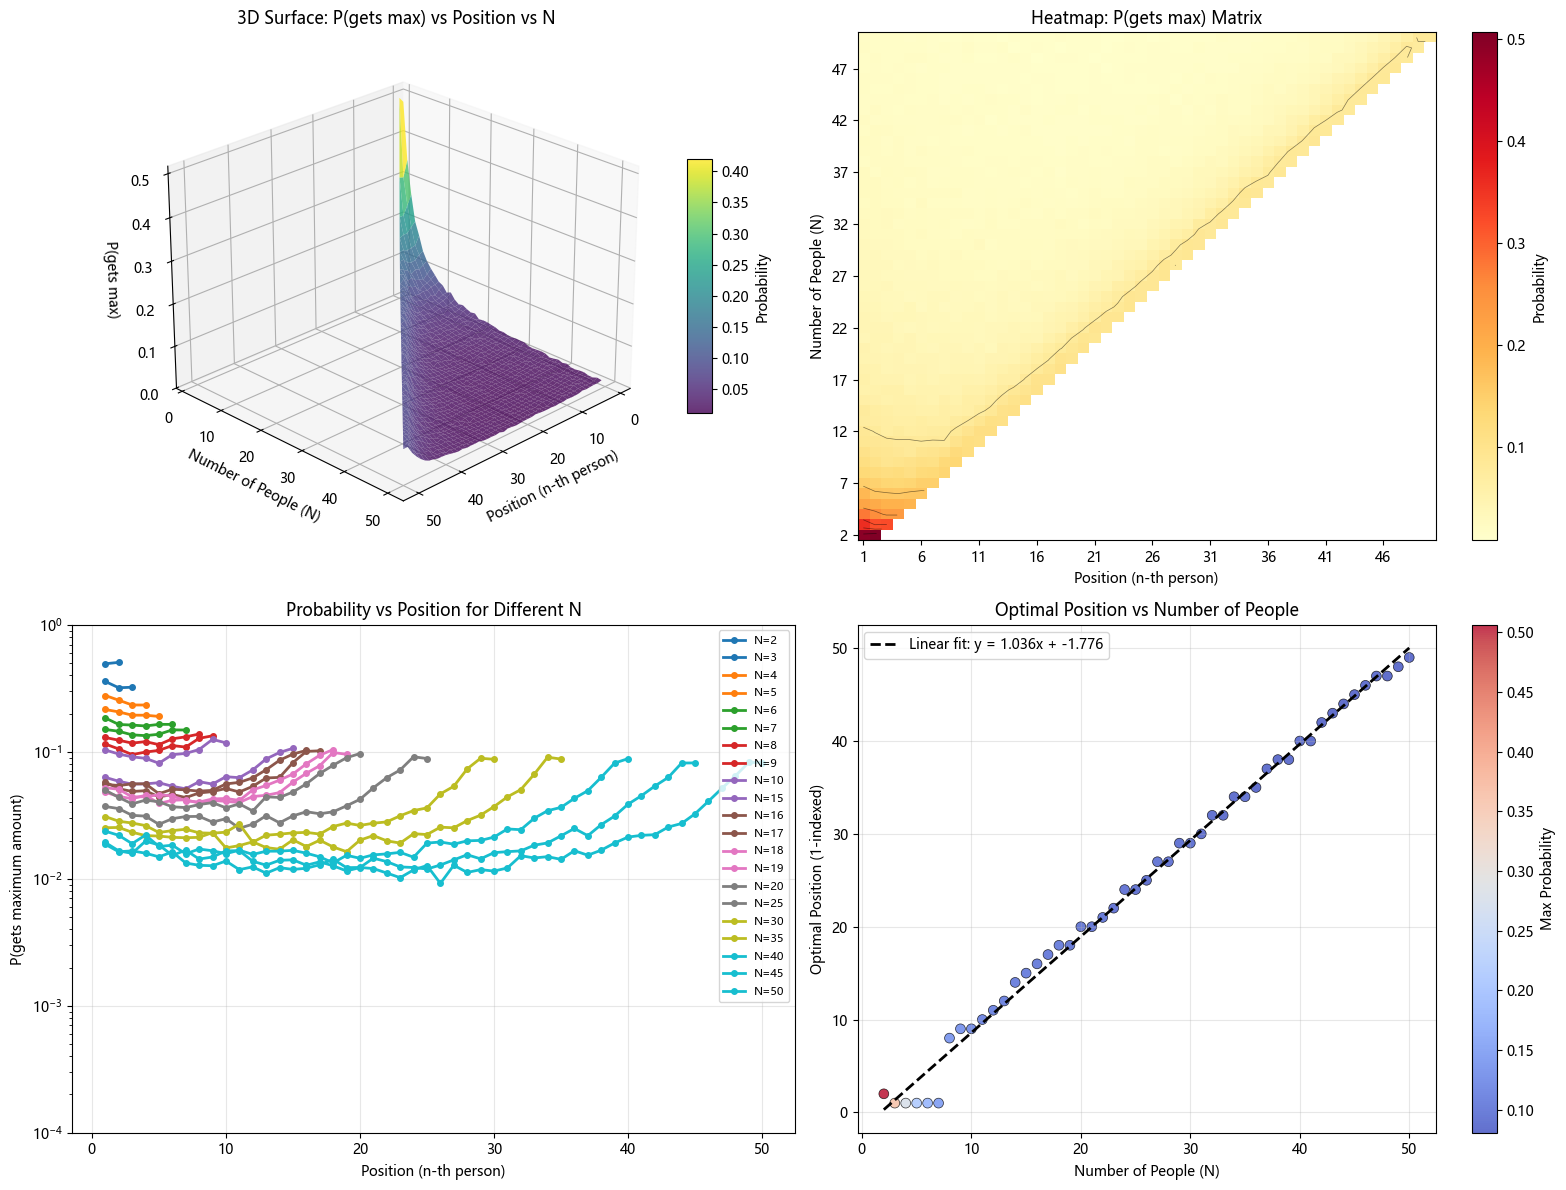

Mean amount analysis saved to: Database\Position_Probability_Analysis\mean_amount_analysis.png


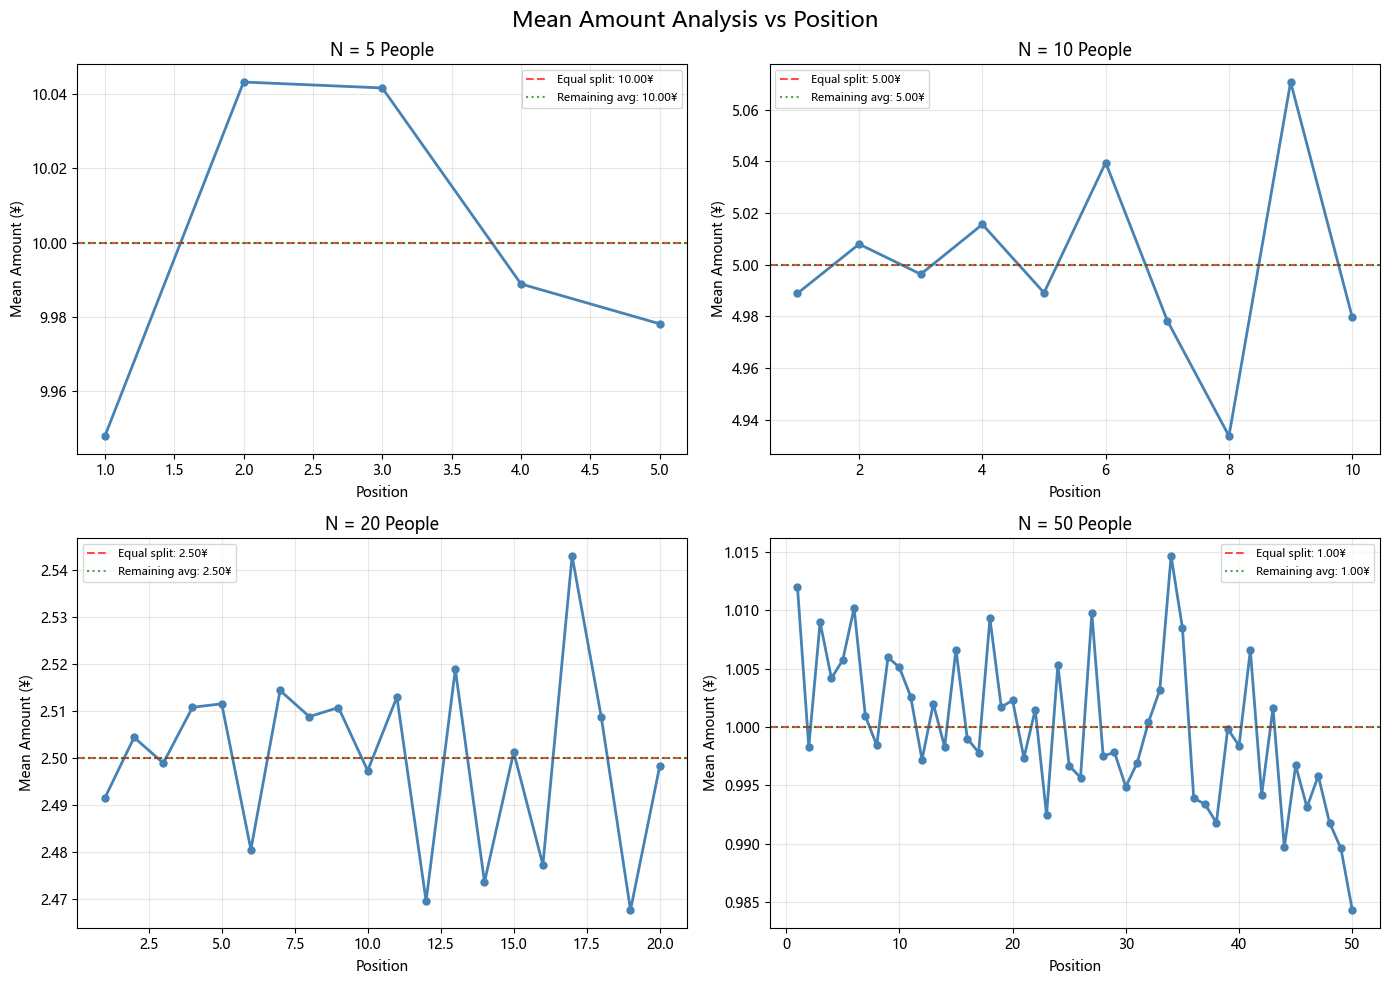

Distribution characteristics saved to: Database\Position_Probability_Analysis\distribution_characteristics.png


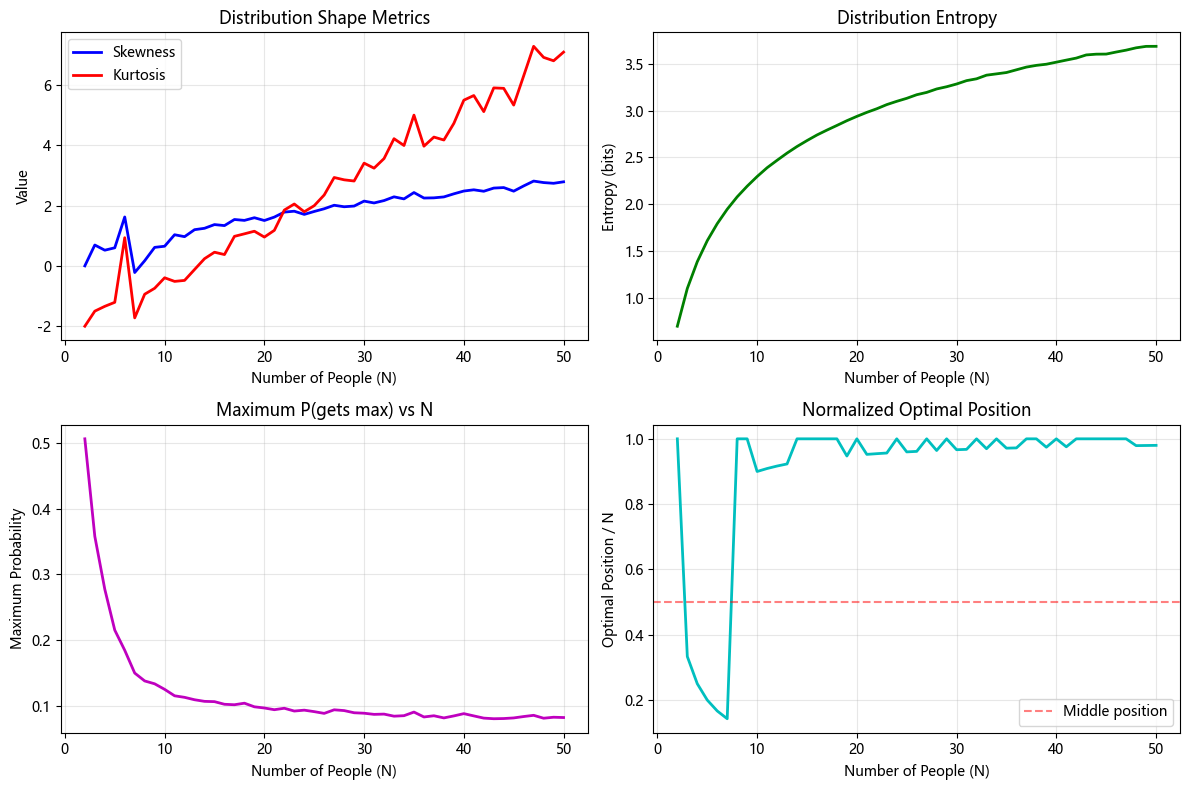

Raw results saved to: Database\Position_Probability_Analysis\position_probability_results.json
Summary report saved to: Database\Position_Probability_Analysis\position_probability_summary.txt

PRACTICAL RECOMMENDATIONS FOR RED ENVELOPE GRABBING

Based on simulation results, here are the optimal strategies:

2-5 people: Grab early (position 1-2)
6-15 people: Aim for positions 2-4
16-30 people: last two
31-50 people: last two
50+ people: last two

Detailed Analysis by Group Size:
--------------------------------------------------
N= 2: Optimal position(s): [2] (P=0.506)
N= 3: Optimal position(s): [1] (P=0.358)
N= 4: Optimal position(s): [1] (P=0.278)
N= 5: Optimal position(s): [1] (P=0.215)
N= 6: Optimal position(s): [1] (P=0.185)
N= 7: Optimal position(s): [1] (P=0.150)
N= 8: Optimal position(s): [8] (P=0.138)
N= 9: Optimal position(s): [9] (P=0.134)
N=10: Optimal position(s): [9] (P=0.125)
N=15: Optimal position(s): [15] (P=0.107)
N=16: Optimal position(s): [16] (P=0.103)
N=17: Optimal

In [27]:
if __name__ == "__main__":
    # Run the analysis
    results = main_position_probability_analysis()

# Task5 Diffusion Model

- `DiffusionModelTrainer.py` Using the 300 samples from Wechat, we trained a **DDPM(Denoising Diffusion Probabilistic Model)**.
- `NewSampleGenerator.py` We used the trained model to generate new sample sets.
- `DistuibutionEvaluator.py` We used ***Peacock's Algorithm (Multidimensional KS Test)*** and ***Energy Distance*** to determine that the 2 sets are from the same hidden distuibution.
- `DataVisualizer.py` Draw similar plots for the generated sample set, with a **much larger set size** to have a better visualization.


## DDPM
- ### Forward Process
  
  ***Objective***: Gradually add **Gaussian Noise** to a ***normalized*** sample $\mathbf{X}_0$ to get nearly pure noise $\mathbf{X}_t$.
  
  **For DDPM**, the process is a **Markov Chain**.
  
  Given parameters $\epsilon \sim \mathcal{N}(0,1)$ and $\beta_t \in (0,1)$
  $$\mathbf{X}_{t+1} = \sqrt{1-\beta_t} \cdot \mathbf{X}_t+\beta_t \cdot \epsilon \Rightarrow \lim_{t\rightarrow \infty} \mathbf{X}_t \sim \mathcal{N}(0,1)$$

  Let $\alpha_t=1-\beta_t, \; \bar{\alpha}_t=\prod_{i=1}^t \alpha_i$, we have:
  $$\mathbf{X}_t = \sqrt{\bar{\alpha}_t} \cdot \mathbf{X}_0 + (1-\bar{\alpha}_t) \cdot \epsilon$$

  or more commonly seen in the form of PDF as: $$q(\mathbf{x}_t\mid \mathbf{x}_0) = \sqrt{\bar{\alpha}_t} \cdot \mathbf{x}_0 + (1-\bar{\alpha}_t) \cdot \epsilon$$

- ### Reverse Process (Denoise)
  
  ***Objective***: Train a **Neural Network** to rebuild data from **Gaussian Noise** $\mathbf{X}_T$.

  The rebuilding process is also a **Markov Chain**. 
  
  Denote $\mathbf{X}_{a:b}$ as the joint distribution of $\mathbf{X}_a,\mathbf{X}_{a+1},\dots ,\mathbf{X}_b$, we have:
  $$ p_\theta(\mathbf{x}_{0:T})= p_\theta(\mathbf{x}_T)\prod_{t=1}^T p_\theta(\mathbf{x}_{t-1}\mid \mathbf{x}_t)$$

  ***Training Objective***: Maximize ***negative log-likelihood*** of generating the real sample $\mathbf{X}_0$.
  $$\theta=\arg\max_\theta (-\log p_\theta(\mathbf{x}_0))$$

  Since it's ***intractable*** to calculate integral of the joint PDF to get $p_\theta(\mathbf{x}_0)$, we calculate the **Evidence Lower Bound(ELBO)**,

  which is the expectation below.
  ![ELBO](./SupportImages/ELBO.png "Derivation of ELBO")

  Then the ELBO can be transformed and simplized to the form below.
  $$-\mathbb{E}_q[\sum_{t>1}D_{KL}(r(\mathbf{x}_{t-1}\mid \mathbf{x}_t,\mathbf{x}_0) || p_\theta(\mathbf{x}_{t-1}\mid \mathbf{x}_t))]$$
  where $r(\mathbf{x}_{t-1}\mid \mathbf{x}_t,\mathbf{x}_0)$ is called the ***true posterior*** since it's conditioned on $\mathbf{x}_0$ in extra, and it has a ***closed-form expression*** we can compute.
  $$r(\mathbf{x}_{t-1}\mid \mathbf{x}_t,\mathbf{x}_0) = \mathcal{N}(\tilde{\mu}_t,\tilde{\beta}_t)$$

  $D_{KL}$ is called the ***KL-Divergence*** which can evaluate **how close** 2 distribution is.

  Therefore, during training, our objective is to ***minimize the distance*** of each **estimated posterior** $p_\theta(\mathbf{x}_{t-1}\mid \mathbf{x}_t)$ to the **true posterior** $r(\mathbf{x}_{t-1}\mid \mathbf{x}_t,\mathbf{x}_0)$.

  Since we have a theorem says **reverse of a Gaussian Markov is also Gaussian**, we set:
  $$p_\theta(\mathbf{x}_{t-1}\mid \mathbf{x}_t) = \mathcal{N}(\mu_\theta,\sigma_t)$$

  In this case, $D_{KL}$ can be simplized to $L^2$ norm:
  $$D_{KL}=\frac{1}{2\sigma_t^2} ||\tilde{\mu}_t-\mu_\theta(\mathbf{x}_t,t)||^2$$

  Given the expression of $\tilde{\mu}_t$ and $\mu_\theta(\mathbf{x}_t,t)$:
  $$\tilde{\mu}_t=\frac{1}{\sqrt{\alpha_t}}(\mathbf{x}_t-\frac{\beta_t}{\sqrt{1-\bar{\alpha_t}}}\cdot \epsilon) \qquad 
  \mu_\theta(\mathbf{x}_t,t)=\frac{1}{\sqrt{\alpha_t}}(\mathbf{x}_t-\frac{\beta_t}{\sqrt{1-\bar{\alpha_t}}}\cdot \epsilon_\theta(\mathbf{x}_t,t))$$
  where $\epsilon_\theta(\mathbf{x}_t,t)$ is the **estimate of noise** added to $\mathbf{X}_0$ to produce $\mathbf{X}_t$

  We have our final ***Loss Function***:
  $$\mathcal{L}=\mathbb{E}_q[\sum_{t>1}\frac{\beta_t^2}{2\sigma_t^2\alpha_t(1-\bar{\alpha}_t)}||\epsilon-\epsilon_\theta(\mathbf{x}_t,t)||^2]$$



## Peacock's Algorithm (Multidimensional KS Test)

**Peacock's Algorithm** (and its generalization by Fasano & Franceschini) is a **multidimensional extension of the Kolmogorov-Smirnov (KS) test**.

In 1D, the KS test finds the maximum vertical distance between the CDFs of two datasets.
$$ D = \sup_x |F_1(x) - F_2(x)| $$

In $\mathbb{R}^d$ for $d > 1$, the notion of "Cumulative Distribution" is not unique because there is no natural ordering of points. Peacock's Approach solves this by defining the CDF in terms of **orthants** (multidimensional quadrants).

For a point $\mathbf{p}$ and a dataset, we calculate the fraction of data points in each of the $2^d$ orthants centered at $\mathbf{p}$. The statistic is the **maximum absolute difference** in these fractions between the generated and real datasets, minimized over all reference points.

$$ D_n = \sup_{\mathbf{p} \in \mathbb{R}^d} \max_{\text{orthants } \mathcal{O}} | P_1(\mathbf{p}, \mathcal{O}) - P_2(\mathbf{p}, \mathcal{O}) | $$

This metric is sensitive to differences in both **location** and **shape** of the distributions. A low value (close to 0) indicates the distributions are similar. We use the Fasano-Franceschini approximation which iterates over data points as reference centers to make it computationally feasible.

## Energy Distance

**Energy Distance** is a statistical distance between the probability distributions of random vectors, which characterizes equality of distributions.

For two independent random vectors $\mathbf{X}$ (from the real dataset) and $\mathbf{Y}$ (from our generated dataset) with CDFs $F$ and $G$, the energy distance is defined as:

$$ D^2(F, G) = 2\mathbb{E}||\mathbf{X} - \mathbf{Y}|| - \mathbb{E}||\mathbf{X} - \mathbf{X}'|| - \mathbb{E}||\mathbf{Y} - \mathbf{Y}'|| $$

where:
* $\mathbb{E}||\mathbf{X} - \mathbf{Y}||$ is the average Euclidean distance between points in the real set and points in the generated set.
* $\mathbb{E}||\mathbf{X} - \mathbf{X}'||$ is the average distance between points within the real set.
* $\mathbb{E}||\mathbf{Y} - \mathbf{Y}'||$ is the average distance between points within the generated set.

**Key Properties**:
1. **$D^2(F, G) = 0$ if and only if $F = G$**.
2. It is **rotation invariant**, meaning it works equally well regardless of how the dimensions are oriented.
3. It effectively captures differences in the "energy" or potential of the distributions. 

We perform a **Permutation Test** on the Energy Distance to obtain a p-value, which tells us if the observed difference is statistically significant. A high p-value ($> 0.05$) generally suggests we cannot distinguish the two distributions, implying our model generated high-quality samples.

## Practical Implementation Optimizations
### Simplified Loss Function
In practice (as in our `DiffusionModelTrainer.py` and in DDPM's original paper), we used the **Simplified Loss(MSE)**.
   $$ \mathcal{L}_{\text{simple}} = \mathbb{E}_{t, \mathbf{x}_0, \epsilon} [||\epsilon - \epsilon_\theta(\mathbf{x}_t, t)||^2] $$

This involves two key changes:
1. **Replacing Sum with Expectation (Stochastic Sampling)**:
   The theoretical calculation requires a sum over all time steps: $\mathcal{L} = \sum_{t=1}^T L_t$.
   
   Mathematically, a sum is equivalent to an expectation over a uniform distribution scaled by a constant:
   $$ \sum_{t=1}^T L_t = T \cdot \mathbb{E}_{t \sim \mathcal{U}(1,T)}[L_t] $$
   
   Therefore, instead of computing the forward/backward pass for **all 1000 steps** for every single sample (which is computationally expensive), we **randomly sample one $t$** for each sample in the batch.
2. **Discarding Weighting Coefficients**:
   Neglecting the weighting term down-weights the loss at small $t$ (where noise is small), encouraging the model to focus on more difficult, noisier steps ($t$ large), which **empirically(as in the original paper)** improves sample quality.

### $n-1$ Degrees of Freedom
Since the total amount of each WRE is a **fixed** 50r, $df=6-1=5$, during training, we only consider **the first 5 dimensions** of each sample, then when generating new samples, the 6th dimension is the amount left, by which we can ensure that for each sample, all dimensions' **value sum to 50**.


## Code

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import json
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as ssd

# ===== Configuration =====
DATA_PATH = os.path.join("Database", "Wechat_Samples.json")
MODEL_DIR = "DiffusionModel"

# NewSampleGenerator Paths
MODEL_PATH = os.path.join(MODEL_DIR, "diffusion_model.pth")
STATS_PATH = os.path.join(MODEL_DIR, "model_stats.json")
OUTPUT_PATH = os.path.join("Database", "DDPM_Generated_Samples.json")

# Training Config
BATCH_SIZE = 64
LR = 1e-3
EPOCHS = 1000
TIMESTEPS = 1000
BETA_START = 1e-4
BETA_END = 0.02
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_DIM = 5
HIDDEN_DIM = 128

# Generation Config
NUM_SAMPLES = 300000

### DiffusionModelTrainer

In [67]:
# ===== Dataset and Data Loading =====
class WechatDataset(Dataset):
    def __init__(self, json_path):
        with open(json_path, "r") as f:
            data = json.load(f)
        self.data = torch.tensor(data, dtype=torch.float32)

        # Keep only first 5 dimensions
        if self.data.shape[1] > 5:
            self.data = self.data[:, :5]

        # Normalization
        self.mean = self.data.mean(dim=0)
        self.std = self.data.std(dim=0)
        self.normalized_data = (self.data - self.mean) / (self.std + 1e-8)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.normalized_data[idx]


# ===== Model Components =====
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        # Main network
        self.input_layer = nn.Linear(input_dim, hidden_dim)

        self.mid_layers = nn.Sequential(
            nn.Linear(hidden_dim + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        self.final_layer = nn.Linear(hidden_dim, input_dim)

    def forward(self, x, t):
        # Embed time
        t_emb = self.time_mlp(t)

        # Embed input
        x_emb = self.input_layer(x)

        # Concatenate x embedding and time embedding
        # Note: We concatenate them or add them. Concatenating to input of interaction layers is common.
        # Here we concat along feature dimension
        h = torch.cat([x_emb, t_emb], dim=1)

        h = self.mid_layers(h)
        return self.final_layer(h)


# ===== Training Logic =====
def get_beta_schedule(timesteps, start, end):
    return torch.linspace(start, end, timesteps)


def train():
    # 1. Prepare Data
    if not os.path.exists(DATA_PATH):
        print(f"Error: Database file not found at {DATA_PATH}")
        return

    dataset = WechatDataset(DATA_PATH)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    # 2. Diffusion Setup
    betas = get_beta_schedule(TIMESTEPS, BETA_START, BETA_END).to(DEVICE)
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)

    # 3. Model Setup
    model = DiffusionModel(INPUT_DIM, HIDDEN_DIM).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.MSELoss()

    # 4. Training Loop
    model.train()
    loss_history = []
    for epoch in range(EPOCHS):
        total_loss = 0
        for batch_idx, batch in enumerate(dataloader):
            batch = batch.to(DEVICE)

            # Sample t uniformly
            t = torch.randint(0, TIMESTEPS, (batch.size(0),), device=DEVICE).long()

            # Sample noise
            noise = torch.randn_like(batch)

            # Forward diffusion q(x_t | x_0)
            # x_t = sqrt(alpha_bar_t) * x_0 + sqrt(1 - alpha_bar_t) * noise
            sqrt_alpha_cumprod_t = torch.sqrt(alphas_cumprod[t])[:, None]
            sqrt_one_minus_alpha_cumprod_t = torch.sqrt(1 - alphas_cumprod[t])[:, None]

            x_t = sqrt_alpha_cumprod_t * batch + sqrt_one_minus_alpha_cumprod_t * noise

            # Predict noise
            noise_pred = model(x_t, t)

            # Loss
            loss = criterion(noise_pred, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)

    # 5. Save Model and Stats
    os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
    
    torch.save(model.state_dict(), MODEL_PATH)
    # Save normalization stats for generation later
    stats = {"mean": dataset.mean.tolist(), "std": dataset.std.tolist()}
    with open(STATS_PATH, "w") as f:
        json.dump(stats, f)

    # 6. Visualize Loss
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Evolution of Training Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

### NewSampleGenerator

In [68]:
def sample(model, num_samples):
    model.eval()
    with torch.no_grad():
        # 1. Prepare betas and alphas
        # Ensure we use the same schedule as training
        betas = get_beta_schedule(TIMESTEPS, BETA_START, BETA_END).to(DEVICE)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, axis=0)

        # 2. Initialize x_T with random noise
        # Start from pure Gaussian noise
        x = torch.randn((num_samples, INPUT_DIM)).to(DEVICE)

        # 3. Iterative denoising
        for t in reversed(range(TIMESTEPS)):

            # Create a batch of time steps
            t_tensor = torch.full((num_samples,), t, device=DEVICE, dtype=torch.long)

            # Predict noise using the model
            predicted_noise = model(x, t_tensor)

            # Get coefficients for this time step
            alpha = alphas[t]
            alpha_cumprod = alphas_cumprod[t]
            beta = betas[t]

            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)

            # Compute x_{t-1} using the reverse diffusion formula
            # x_{t-1} = (1/sqrt(alpha)) * (x_t - ((1-alpha)/sqrt(1-alpha_cumprod)) * eps) + sigma * z

            inv_sqrt_alpha = 1 / torch.sqrt(alpha)
            noise_coeff = (1 - alpha) / torch.sqrt(1 - alpha_cumprod)
            sigma = torch.sqrt(beta)  # Using sigma_t^2 = beta_t

            x = inv_sqrt_alpha * (x - noise_coeff * predicted_noise) + sigma * noise

    return x


def generate_samples(num_samples=NUM_SAMPLES, output_file=OUTPUT_PATH):
    # Check if model exists
    if not os.path.exists(MODEL_PATH):
        print(f"Error: Model file not found at {MODEL_PATH}")
        print("Please train the model first using DiffusionModelTrainer.py")
        return

    # Initialize Model
    model = DiffusionModel(INPUT_DIM, HIDDEN_DIM).to(DEVICE)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))

    # Load Normalization Stats
    if os.path.exists(STATS_PATH):
        with open(STATS_PATH, "r") as f:
            stats = json.load(f)
        mean = torch.tensor(stats["mean"]).to(DEVICE)
        std = torch.tensor(stats["std"]).to(DEVICE)
    else:
        print(f"Error: Stats file not found at {STATS_PATH}")
        return

    # Generate
    generated_data_norm = sample(model, num_samples)

    # Denormalize
    # x = x_norm * std + mean
    generated_data = generated_data_norm * (std + 1e-8) + mean

    # Calculate 6th dimension: 50 - sum(first 5 dims)
    # This was trained as 5D model with 6th dim inferred
    dim6 = 50.0 - torch.sum(generated_data, dim=1, keepdim=True)
    generated_data = torch.cat([generated_data, dim6], dim=1)

    # Save to JSON
    generated_list = generated_data.cpu().numpy().tolist()

    # Round floats to 2 decimal places
    rounded_list = [[round(float(v), 2) for v in row] for row in generated_list]

    # Ensure output directory exists
    os.makedirs(os.path.dirname(output_file), exist_ok=True)

    with open(output_file, "w") as f:
        json.dump(rounded_list, f, indent=4)

### DistributionEvaluator

In [69]:
# Set seed for reproducibility
np.random.seed(42)

def load_data(filepath):
    with open(filepath, "r") as f:
        data = json.load(f)
    return np.array(data)


def energy_distance(u, v):
    """
    Compute the energy distance between two distributions u and v.
    d^2(u, v) = 2 E||u - v|| - E||u - u'|| - E||v - v'||

    If inputs are very large, we subsample to keep computation feasible.
    """
    # Subsample if too large to avoid O(N^2) memory/time issues
    # Limit to e.g. 2000 samples for the distance matrix calculation
    max_samples = 2000

    if len(u) > max_samples:
        indices = np.random.choice(len(u), max_samples, replace=False)
        u = u[indices]

    if len(v) > max_samples:
        indices = np.random.choice(len(v), max_samples, replace=False)
        v = v[indices]

    # Efficient pairwise distance calculation
    d_uv = ssd.cdist(u, v, "euclidean")
    d_uu = ssd.cdist(u, u, "euclidean")
    d_vv = ssd.cdist(v, v, "euclidean")

    E_uv = np.mean(d_uv)
    E_uu = np.mean(d_uu)
    E_vv = np.mean(d_vv)

    result = 2 * E_uv - E_uu - E_vv
    return result


def energy_distance_permutation_test(u, v, n_permutations=100):
    """
    Perform a permutation test to get a p-value for the Energy Distance.
    H0: u and v are from the same distribution.
    """
    # Subsample for speed if needed (keep consistent with energy_distance call)
    max_samples = 1000  # smaller for permutation loop
    if len(u) > max_samples:
        u = u[np.random.choice(len(u), max_samples, replace=False)]
    if len(v) > max_samples:
        v = v[np.random.choice(len(v), max_samples, replace=False)]

    n_u = len(u)
    n_v = len(v)
    combined = np.vstack([u, v])

    # Precompute distance matrix
    d_mat = ssd.cdist(combined, combined, "euclidean")

    def get_e_stat(indices_u, indices_v):
        d_uu = d_mat[np.ix_(indices_u, indices_u)]
        d_vv = d_mat[np.ix_(indices_v, indices_v)]
        d_uv = d_mat[np.ix_(indices_u, indices_v)]

        return 2 * np.mean(d_uv) - np.mean(d_uu) - np.mean(d_vv)

    # Observed
    obs_stat = get_e_stat(np.arange(n_u), np.arange(n_u, n_u + n_v))

    count_greater = 0
    all_indices = np.arange(n_u + n_v)

    for _ in range(n_permutations):
        shuffled = np.random.permutation(all_indices)
        idx_u = shuffled[:n_u]
        idx_v = shuffled[n_u:]

        perm_stat = get_e_stat(idx_u, idx_v)
        if perm_stat >= obs_stat:
            count_greater += 1

    p_value = (count_greater + 1) / (n_permutations + 1)
    return obs_stat, p_value


def peacock_test(u, v):
    """
    Multidimensional Kolmogorov-Smirnov test (Fasano-Franceschini, 1987).
    Often referred to as Peacock's Algorithm (which was the 2D precursor).

    D = max | P(u in orthant) - P(v in orthant) |
    over all orthants defined by all data points.
    """

    # Subsample for feasibility
    # The number of orthants is 2^d. For d=6, 64 orthants.
    # We iterate over points to define the origin.
    # If N is large, this is O(N^2). We limit N.
    n_limit = 500  # limit reference points (centers)

    # We can use all points for calculating probabilities, but limit the centers.
    # However, to be consistent and fast, we'll subsample the data used for counting as well
    # if it's extremely large, but 1000-2000 is fine for counting.

    # Let's keep v (generated) large-ish but subsampled, and u (real) as is if small.
    # Subsampling
    u_sub = u
    v_sub = v

    # Limit the "points" we check (the grid centers) to a manageable union
    # We combine u and v, then sample from them to get test centers.

    combined = np.vstack([u, v])
    if len(combined) > n_limit:
        center_indices = np.random.choice(len(combined), n_limit, replace=False)
        centers = combined[center_indices]
    else:
        centers = combined

    # For accuracy, we should check counts against the full (or large subsample) sets
    # But evaluating 30000 points 64 times for 1000 centers is 1.9e9 ops. Too slow for python loop.
    # Vectorization is key.

    # Reduce v to a manageable size for density estimation, e.g. 2000
    if len(v_sub) > 2000:
        v_sub = v_sub[np.random.choice(len(v_sub), 2000, replace=False)]

    # Dimensions
    dims = u.shape[1]
    n_u = len(u_sub)
    n_v = len(v_sub)

    max_d = 0.0

    # Vectorized implementation
    # For each center, we have 2^dims orthants.
    # Instead of iterating 2^dims, we can just process the relationship of all points to a center.
    # A point p is in orthant O_k of center c if (p > c) matches the bool signature of k.

    for i, center in enumerate(centers):
        # Broadcast comparison: (N, D) > (1, D) -> (N, D) boolean
        # u_bool: (N_u, D), true if u_coord > center_coord
        diff_u = u_sub > center  # shape (N_u, D)
        diff_v = v_sub > center  # shape (N_v, D)

        # We need to group these by orthant.
        # An orthant is defined by the tuple of booleans.
        # efficiently, we can convert boolean vector to integer index for orthant
        # e.g. [True, False, True] -> 101 -> 5

        # Powers of 2 for conversion
        powers = 2 ** np.arange(dims)

        # (N, D) * (D,) -> (N,) sum over axis 1
        orthant_indices_u = (diff_u.astype(int) * powers).sum(axis=1)
        orthant_indices_v = (diff_v.astype(int) * powers).sum(axis=1)

        # Count occurrences of each orthant 0..2^d-1
        # using bincount is fast
        counts_u = np.bincount(orthant_indices_u, minlength=2**dims)
        counts_v = np.bincount(orthant_indices_v, minlength=2**dims)

        # Convert to frequencies
        freq_u = counts_u / n_u
        freq_v = counts_v / n_v

        # Max diff for this center
        d_center = np.max(np.abs(freq_u - freq_v))

        if d_center > max_d:
            max_d = d_center

    return max_d


def peacock_permutation_test(u, v, n_permutations=100):
    """
    Perform a permutation test to get a p-value for the Multidimensional KS statistic.
    """
    # Observed statistic
    obs_d = peacock_test(u, v)

    n_u = len(u)
    n_v = len(v)
    combined = np.vstack([u, v])
    all_indices = np.arange(n_u + n_v)

    count_greater = 0

    for k in range(n_permutations):
        shuffled = np.random.permutation(all_indices)
        idx_u = shuffled[:n_u]
        idx_v = shuffled[n_u:]

        u_perm = combined[idx_u]
        v_perm = combined[idx_v]

        perm_d = peacock_test(u_perm, v_perm)

        if perm_d >= obs_d:
            count_greater += 1

    p_value = (count_greater + 1) / (n_permutations + 1)
    return obs_d, p_value


def perform_tests():
    # Use global paths defined in configuration
    wechat_path = DATA_PATH
    generated_path = OUTPUT_PATH

    if not os.path.exists(wechat_path) or not os.path.exists(generated_path):
        print(f"Data files not found:\n{wechat_path}\n{generated_path}")
        return

    wechat_data = load_data(wechat_path)
    generated_data = load_data(generated_path)

    # -----------------------------------------------------
    # EVALUATION: All 6 Dimensions (Standard)
    # -----------------------------------------------------
    if wechat_data.shape[1] >= 6 and generated_data.shape[1] >= 6:
        print("\n" + "=" * 60)
        print("DISTRIBUTION HYPOTHESIS TESTING (6 DIMENSIONS)")
        print(
            "H0: The generated samples come from the same distribution as the real data."
        )
        print("Alpha Level: 0.05")
        print("=" * 60)

        w_6d = wechat_data[:, :6]
        g_6d = generated_data[:, :6]

        # 1. Peacock's Test
        print("\n[Test 1] Peacock's Multidimensional KS Test")
        ks_stat_6d, ks_p_6d = peacock_permutation_test(
            w_6d, g_6d, n_permutations=200
        )  # Increased for better resolution
        print("-" * 40)
        print(f"  Statistic : {ks_stat_6d:.6f}")
        print(f"  P-value   : {ks_p_6d:.4f}")
        print(
            f"  Result    : {'REJECT H0 (Distributions Different)' if ks_p_6d < 0.05 else 'FAIL TO REJECT H0 (Distributions Consistent)'}"
        )

        # 2. Energy Distance Test
        print("\n[Test 2] Energy Distance Test")
        ed_6d, ed_p_6d = energy_distance_permutation_test(
            w_6d, g_6d, n_permutations=200
        )
        print("-" * 40)
        print(f"  Statistic : {ed_6d:.6f}")
        print(f"  P-value   : {ed_p_6d:.4f}")
        print(
            f"  Result    : {'REJECT H0 (Distributions Different)' if ed_p_6d < 0.05 else 'FAIL TO REJECT H0 (Distributions Consistent)'}"
        )

        print("\n" + "=" * 60)
    else:
        print("\nError: Data has fewer than 6 dimensions.")

### Main

Model found at DiffusionModel\diffusion_model.pth.


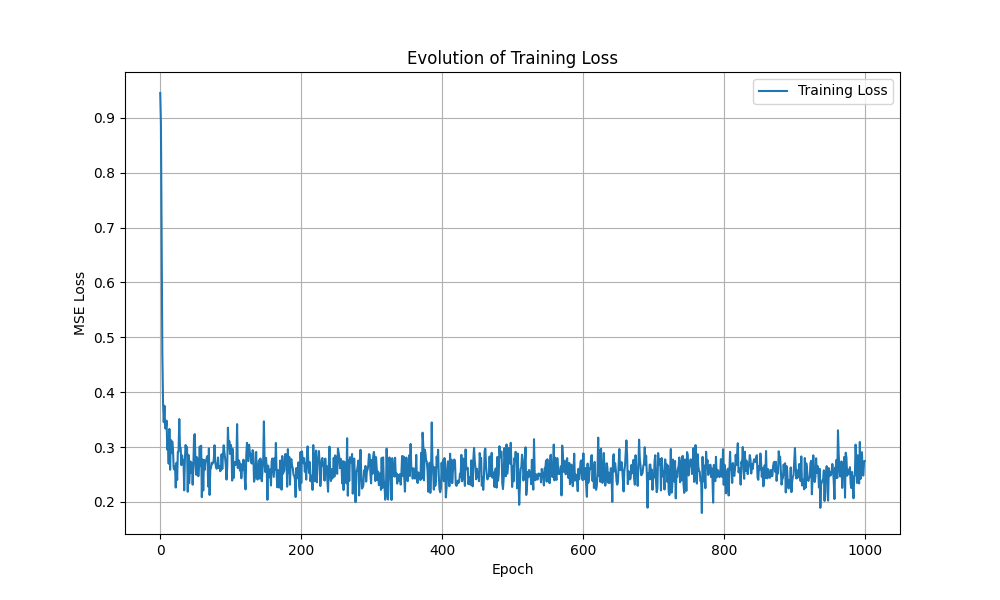

Generated data found at Database\DDPM_Generated_Samples.json.
Starting Hypothesis Tests...

DISTRIBUTION HYPOTHESIS TESTING (6 DIMENSIONS)
H0: The generated samples come from the same distribution as the real data.
Alpha Level: 0.05

[Test 1] Peacock's Multidimensional KS Test
----------------------------------------
  Statistic : 0.092730
  P-value   : 0.1493
  Result    : FAIL TO REJECT H0 (Distributions Consistent)

[Test 2] Energy Distance Test
----------------------------------------
  Statistic : 0.100549
  P-value   : 0.1841
  Result    : FAIL TO REJECT H0 (Distributions Consistent)



<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

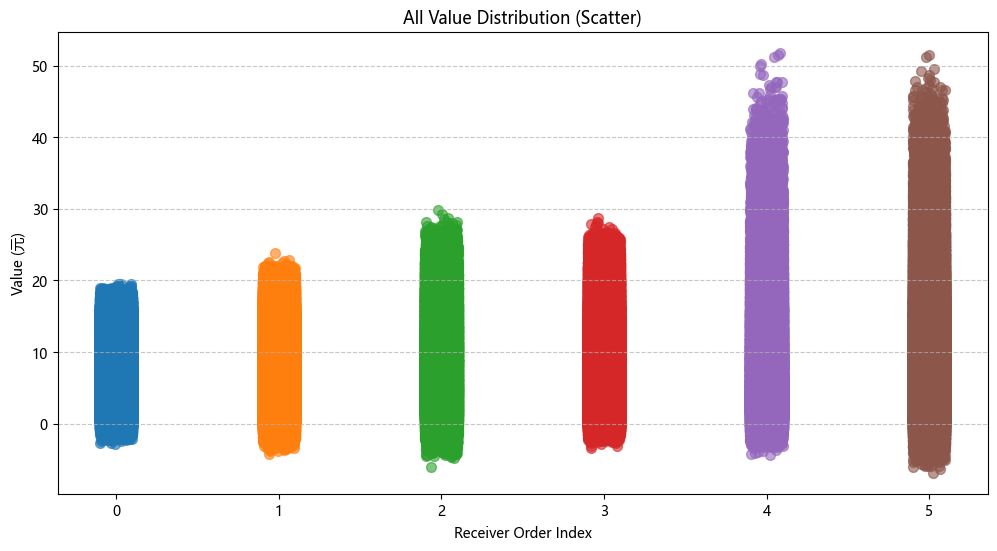

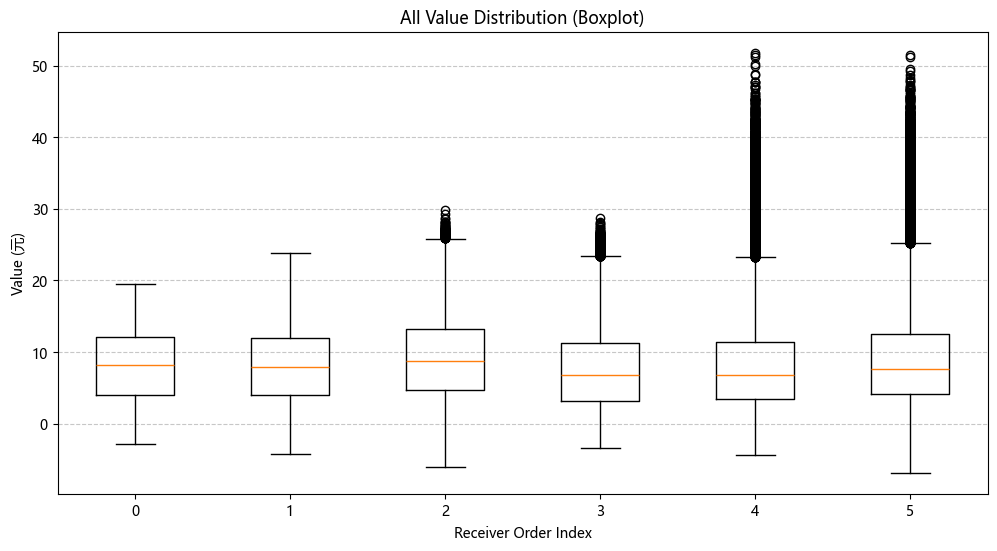

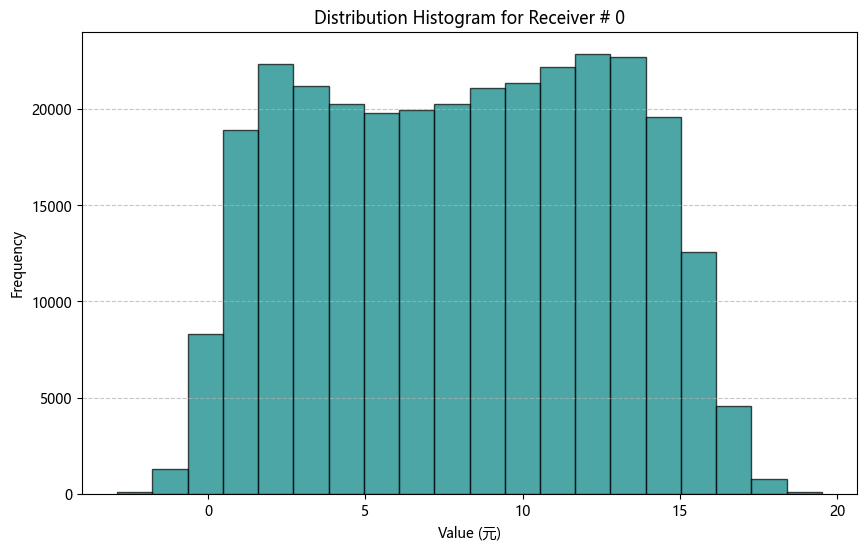

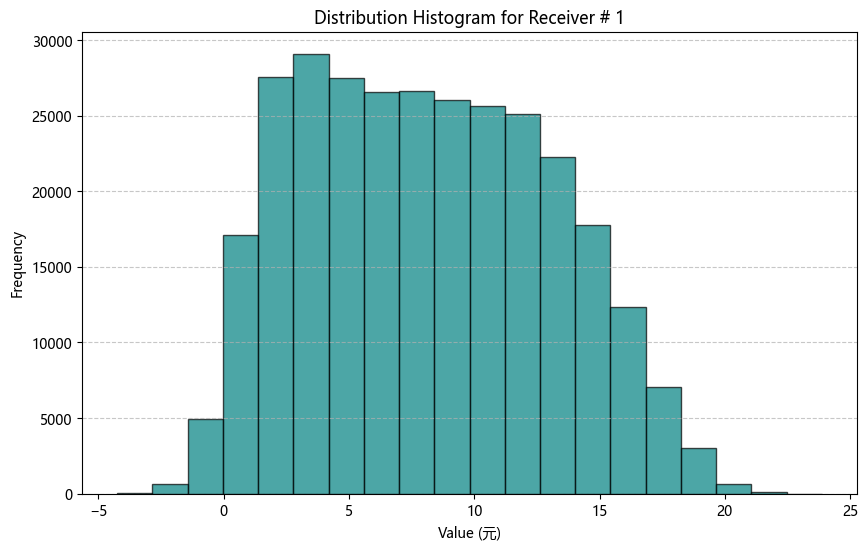

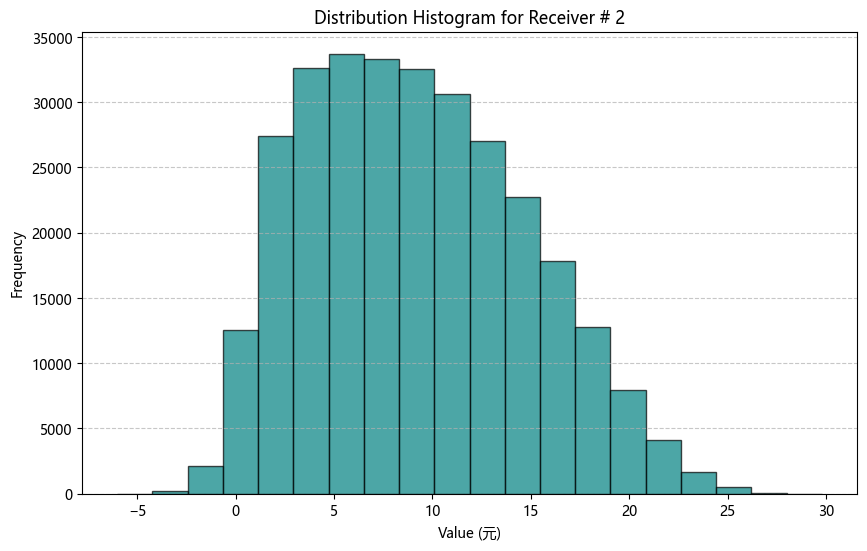

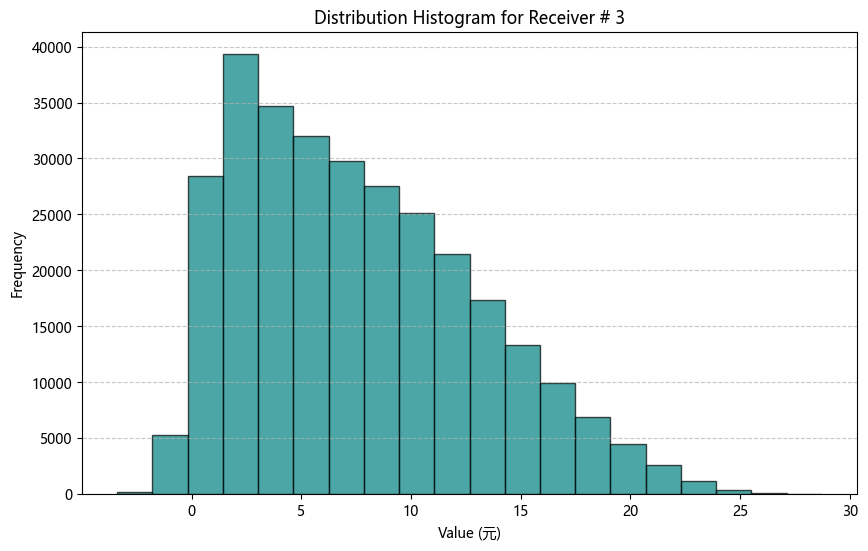

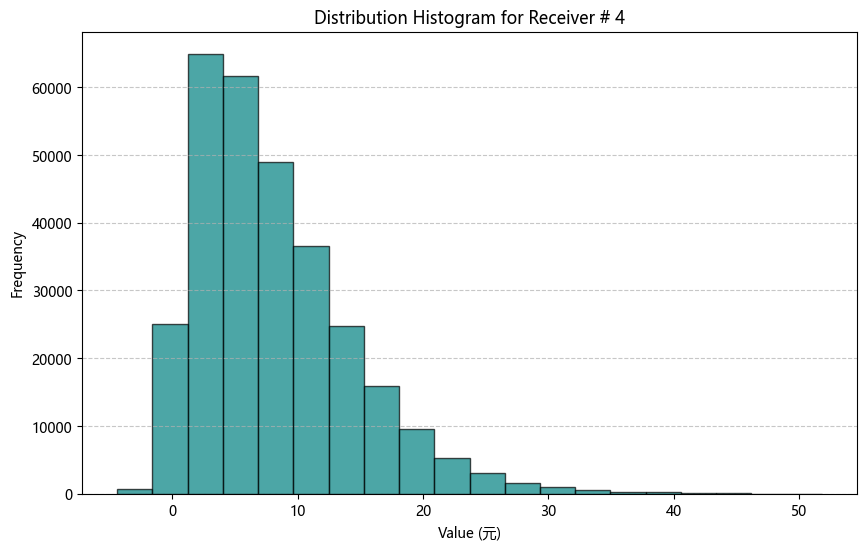

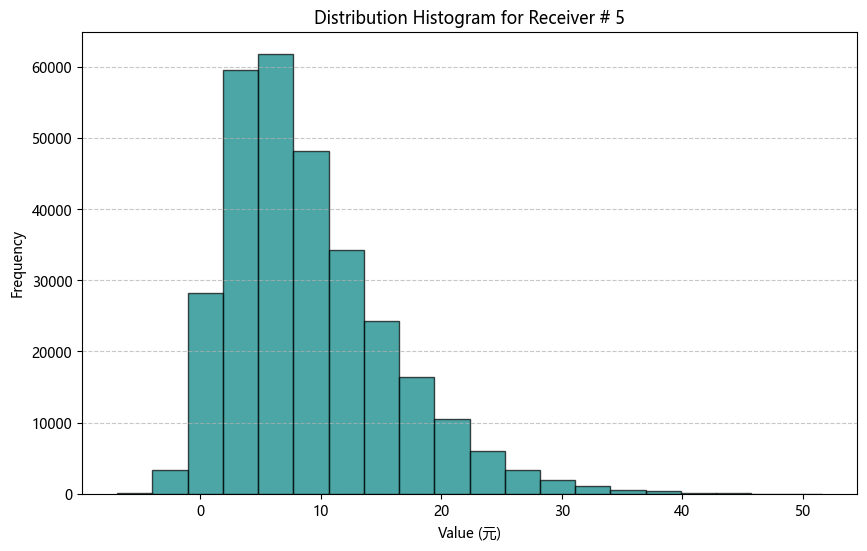

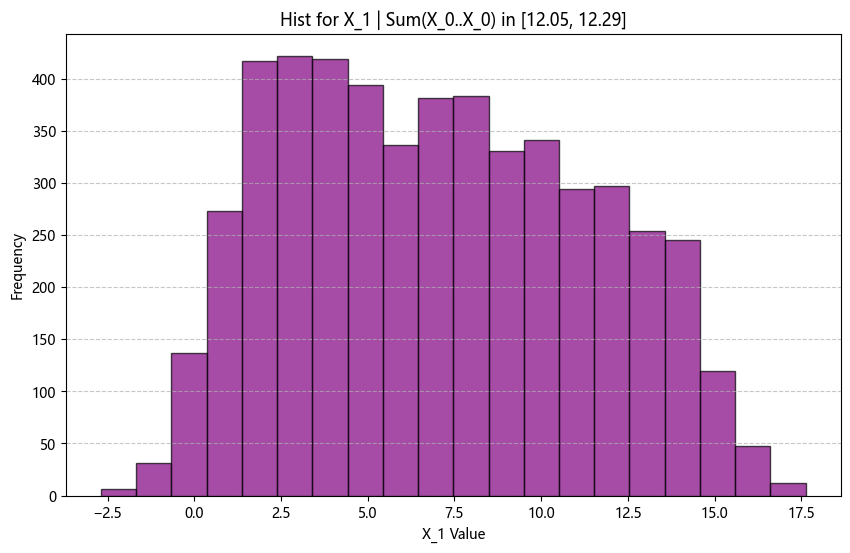

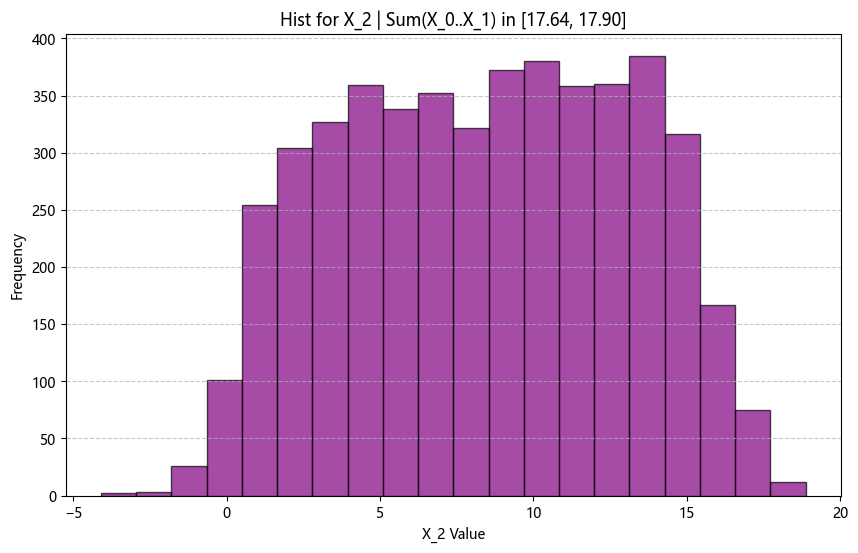

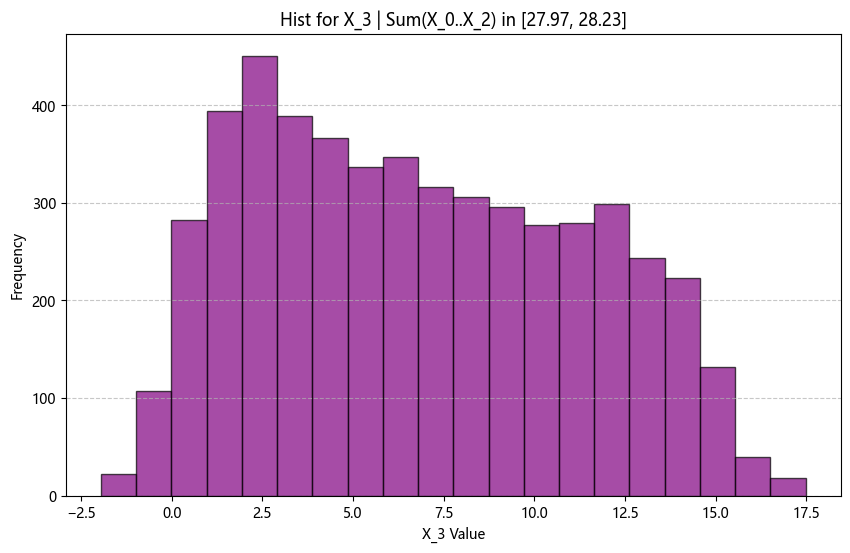

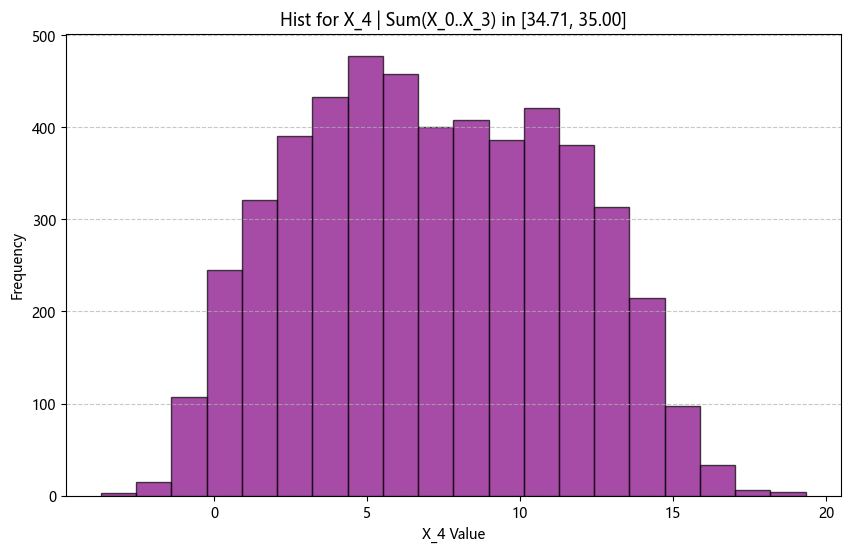

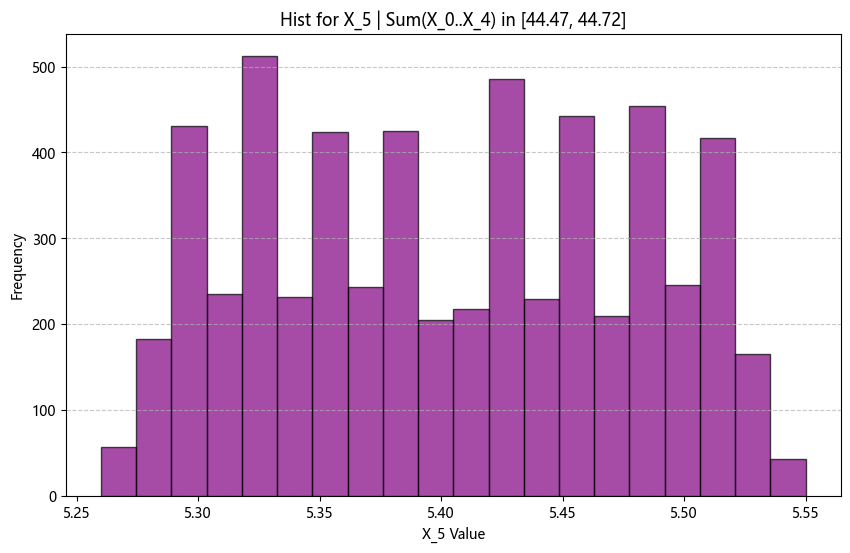

In [70]:
# 1. Check for Model / Train if needed
if not os.path.exists(MODEL_PATH) or not os.path.exists(STATS_PATH):
    print(f"Model or stats not found at {MODEL_PATH}. Starting training...")
    train()
    print("Training complete.")
else:
    print(f"Model found at {MODEL_PATH}.")
    # Show loss evolution if it exists
    loss_img_path = os.path.join(MODEL_DIR, "loss_evolution.png")
    if os.path.exists(loss_img_path):
        from IPython.display import Image, display
        display(Image(filename=loss_img_path))
    else:
        print("Loss evolution plot not found.")

# 2. Check for Generated Data / Generate if needed
if not os.path.exists(OUTPUT_PATH):
    print(f"Generated data not found at {OUTPUT_PATH}. Generating {NUM_SAMPLES} samples...")
    generate_samples()
    print("Generation complete.")
else:
    print(f"Generated data found at {OUTPUT_PATH}.")

# 3. Perform Hypothesis Tests
print("Starting Hypothesis Tests...")
perform_tests()

# 4. Visualize Generated Data
data_path = os.path.join(DATABASE_DIR, "DDPM_Generated_Samples.json")
if os.path.exists(data_path):
    try:
        with open(data_path, "r", encoding="utf-8") as f:
            data = json.load(f)
        visualize_data(data)
    except Exception as e:
        print(f"Error loading data from file: {e}")

# Task7 Further Exploration
### (d) User-specific WRE mechanism
Based on the original model, we further enhance it to satisfy different groups of user's need and apply it in many different situations
### Example 1: Child Group
#### Problem: Children want fairness due to differences in amounts received.
#### Optimization: Reduce randomness, increase fairness, ensuring the amount difference is not too large.
#### Solution: "Gentle Randomness" + "Minimum Guarantee Constraint"

## (e) Fairness-ware WRE mechanism
### Purpose:
A compensation mechanism which change the weights of algorithm when someone unluckily get less money than other people.
### Solution:
#### 1. Record the historical average income of each user.
#### 2. When someone's amount is consistently below average → give them higher weight or priority guarantee in the next red envelope distribution.
#### 3. Use a "fairness coefficient" to adjust allocation probabilities.

In [36]:
import numpy as np
from collections import defaultdict

class FairnessAwareRedEnvelope:
    def __init__(self):
        self.history = defaultdict(list)  # user_id -> list of received amounts
        self.total_sent = 0

    def send_red_envelope(self, total_amount, users, sender=None):
        """
        发送一个红包，考虑历史公平性
        """
        n = len(users)
        if n == 0:
            return []

        # Step 1: 计算每个用户的当前平均收益
        avg_amounts = {}
        for u in users:
            if u in self.history:
                avg_amounts[u] = sum(self.history[u]) / len(self.history[u])
            else:
                avg_amounts[u] = 0.0

        # Step 2: 计算“公平分数”：越低的人越需要补偿
        fairness_scores = {u: 1.0 / (avg_amounts[u] + 0.1) for u in users}
        total_score = sum(fairness_scores.values())
        weights = {u: fairness_scores[u] / total_score for u in users}

        # Step 3: 基于权重进行带偏置的分配
        amounts = []
        remaining = total_amount
        remaining_people = n

        for i in range(n - 1):
            u = users[i]
            # 使用权重影响期望值
            expected = total_amount * weights[u]
            # 控制波动范围
            upper_bound = min(2 * expected, remaining)
            lower_bound = 0.01
            new_amount = np.random.uniform(lower_bound, upper_bound)
            new_amount = min(new_amount, remaining - (remaining_people - 1) * 0.01)
            amounts.append(round(new_amount, 2))
            remaining -= new_amount
            remaining_people -= 1

        amounts.append(round(remaining, 2))

        # Step 4: 更新历史记录
        for i, u in enumerate(users):
            self.history[u].append(amounts[i])

        return amounts

faire = FairnessAwareRedEnvelope()
users = ['A', 'B', 'C', 'D', 'E']

# 第一次发红包
print("Round 1:", faire.send_red_envelope(50.0, users))

# 第二次发红包
print("Round 2:", faire.send_red_envelope(50.0, users))

# 第三次发红包：假设 C 很不幸，总金额很低
print("Round 3:", faire.send_red_envelope(50.0, users))

Round 1: [15.78, 3.4, 4.95, 7.74, 18.14]
Round 2: [7.82, 3.22, 0.57, 2.4, 35.99]
Round 3: [7.99, 25.81, 14.99, 0.84, 0.37]


In [37]:
import numpy as np

def generate_children_red_envelope(total_amount=50.0, num_people=6):
    # 每人基础金额 = total / num_people
    base = total_amount / num_people
    # 加上微小扰动，但仍控制在 ±10% 范围内
    amounts = []
    remaining = total_amount

    for i in range(num_people - 1):
        # 添加小范围浮动，确保不会太离谱
        fluctuation = np.random.uniform(-0.1 * base, 0.1 * base)
        amount = max(0.01, base + fluctuation)
        # 确保不超过剩余额度
        amount = min(amount, remaining - (num_people - 1 - i) * 0.01)
        amounts.append(round(float(amount), 2))
        remaining -= amount

    last_amount = round(float(remaining), 2)
    amounts.append(last_amount)

    return amounts

amounts = generate_children_red_envelope(30.0, 6)
print("🎈 幼儿园小朋友抢红包示例 (总额30元，6个小朋友)")
print("分配结果:", amounts)
print("每人金额:", [f"{amount}元" for amount in amounts])
print("最大金额:", max(amounts), "元")
print("最小金额:", min(amounts), "元")
print("金额差值:", max(amounts) - min(amounts), "元")

🎈 幼儿园小朋友抢红包示例 (总额30元，6个小朋友)
分配结果: [5.07, 4.75, 4.88, 5.12, 4.52, 5.66]
每人金额: ['5.07元', '4.75元', '4.88元', '5.12元', '4.52元', '5.66元']
最大金额: 5.66 元
最小金额: 4.52 元
金额差值: 1.1400000000000006 元


### Example 2: Company Group
#### Problem: When the boss sends a red envelope, they want to show generosity while avoiding embarrassment caused by large disparities among employees.
#### Optimization: Set aside a "bonus" for the boss (e.g., a fixed proportion for themselves), then use a relatively fair distribution for employees.
#### Solution: "Boss Privilege" + "Employee Gentle Randomness"

In [38]:
def generate_company_red_envelope(total_amount=50.0, roles=['boss', 'employee', 'employee', 'employee', 'employee', 'employee']):
    # 假设 boss 不想抢太多，只拿 1～3 元作为象征
    # 其他人按正常分布
    amounts = []
    remaining = total_amount
    role_map = {'boss': 0.01, 'employee': 0.01}  # 最低限额

    # 先处理非 boss 成员
    non_boss_count = sum(1 for r in roles if r != 'boss')
    non_boss_avg = (total_amount - 3.0) / non_boss_count  # 给 boss 预留 3 元上限

    for role in roles:
        if role == 'boss':
            boss_amount = np.random.uniform(0.01, 3.0)
            amounts.append(round(boss_amount, 2))
            remaining -= boss_amount
        else:
            # 正常员工分配
            upper_bound = min(2 * non_boss_avg, remaining)
            amount = np.random.uniform(0.01, upper_bound)
            amount = min(amount, remaining - (non_boss_count - len(amounts)) * 0.01)
            amounts.append(round(amount, 2))
            remaining -= amount

    # 最后一人补足
    if len(amounts) < len(roles):
        amounts.append(round(remaining, 2))

    return amounts

roles = ['boss', 'employee', 'employee', 'employee', 'employee', 'employee']
amounts = generate_company_red_envelope(100.0, roles)
print("\n🏢 公司团队抢红包示例 (总额100元，1位老板+5位员工)")
print("分配结果:", amounts)
print("老板获得:", amounts[0], "元")
print("员工获得:", [f"{amount}元" for amount in amounts[1:]])
print("员工平均:", round(sum(amounts[1:]) / 5, 2), "元")


🏢 公司团队抢红包示例 (总额100元，1位老板+5位员工)
分配结果: [2.23, 5.3, 12.91, 27.5, 30.34, 0.74]
老板获得: 2.23 元
员工获得: ['5.3元', '12.91元', '27.5元', '30.34元', '0.74元']
员工平均: 15.36 元


### Example 3: Family Member Group
#### Problem: Family relationships are complex; sometimes there's a desire to give more to closer relatives.
#### Optimization: Introduce "intimacy weights" to influence the random range or final amounts during distribution.
#### Solution: "Weight Influences Random Upper Limit"

In [39]:
def generate_family_red_envelope(total_amount=88.0, weights=None, members=None):
    if weights is None:
        # 默认权重：父母(高)、配偶/子女(中)、远亲(低)
        weights = [3.0, 3.0, 2.0, 2.0, 1.0, 0.5]
    if members is None:
        members = ['父亲', '母亲', '儿子', '女儿', '叔叔', '表哥']

    num_people = len(weights)
    normalized_weights = [w / sum(weights) for w in weights]

    amounts = []
    remaining = total_amount

    for i in range(num_people - 1):
        weight = normalized_weights[i]
        expected = total_amount * weight
        fluctuation = np.random.uniform(-0.2 * expected, 0.2 * expected)
        amount = max(0.01, expected + fluctuation)
        amount = min(amount, remaining - (num_people - 1 - i) * 0.01)
        amounts.append(round(float(amount), 2))
        remaining -= amount

    amounts.append(round(float(remaining), 2))

    return dict(zip(members, amounts))

weights = [3.0, 3.0, 2.0, 2.0, 1.0, 0.5]  # 父母>子女>叔叔>表哥
members = ['父亲', '母亲', '儿子', '女儿', '叔叔', '表哥']
result = generate_family_red_envelope(88.0, weights, members)

print("\n👨‍👩‍👧‍👦 家庭春节红包示例 (总额88元，6位亲戚)")
print("分配结果:")
for member, amount in result.items():
    print(f"  {member}: {amount}元")

print("\n金额排序(从高到低):")
sorted_result = sorted(result.items(), key=lambda x: x[1], reverse=True)
for member, amount in sorted_result:
    print(f"  {member}: {amount}元")


👨‍👩‍👧‍👦 家庭春节红包示例 (总额88元，6位亲戚)
分配结果:
  父亲: 26.94元
  母亲: 22.45元
  儿子: 16.08元
  女儿: 12.89元
  叔叔: 8.66元
  表哥: 0.98元

金额排序(从高到低):
  父亲: 26.94元
  母亲: 22.45元
  儿子: 16.08元
  女儿: 12.89元
  叔叔: 8.66元
  表哥: 0.98元
